## Setup

In [1]:
import sys
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import ast

import numpy as np
import pandas as pd
import random
import isuelogit as isl
import glob
import time

from sklearn import preprocessing
from sklearn.impute import SimpleImputer

import geopandas as gpd
import contextily as ctx

In [2]:
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')

In [3]:
# Path management
main_dir = str(Path(os.path.abspath('')).parents[1])
os.chdir(main_dir)
print('main dir:', main_dir)

sys.path.append(os.path.join(main_dir, 'src'))

isl.config.dirs['read_network_data'] = "input/network-data/fresno/"

main dir: /Users/pablo/github/nesuelogit


In [4]:
%load_ext autoreload
%autoreload 2

from pesuelogit.networks import read_OD
from pesuelogit.etl import data_curation, add_period_id

# Internal modules
from nesuelogit.models import NESUELOGIT, ODParameters, UtilityParameters, BPR, MLP, KernelConstraint, \
    GenerationParameters, train_kfold, compute_generated_trips, compute_generation_factors, \
    compute_benchmark_metrics, PolynomialLayer, compute_baseline_predictions_kfold
from nesuelogit.etl import build_network, get_tensors_by_year
from nesuelogit.visualizations import  plot_predictive_performance, plot_metrics_kfold, plot_top_od_flows_periods, \
    plot_utility_parameters_periods, plot_rr_by_period, plot_rr_by_period_models, plot_total_trips_models, \
    plot_performance_functions, plot_flow_vs_traveltime, plot_flow_interaction_matrix, plot_parameters_kfold, \
    plot_convergence_estimates, plot_parameters, plot_baselines_kfold,  plot_congestion_maps
from nesuelogit.metrics import mse, btcg_mse, mnrmse, mape, mdape, nrmse, r2_score, zscore, z2score
from nesuelogit.utils import read_paths

In [5]:
# Seed for reproducibility
_SEED = 2023
np.random.seed(_SEED)
random.seed(_SEED)
tf.random.set_seed(_SEED)

In [6]:
# To report global runtime
t0_global = time.time()

In [7]:
# Set timestamp to add in the filenames that are written in disk
ts = datetime.now().strftime('%y%m%d%H%M%S')
print('Timestamp:',ts)

Timestamp: 231210233518


## Read nodes and link-specific data

In [8]:
nodes_df = pd.read_csv('./input/network-data/fresno/nodes/fresno-nodes-gis-data.csv')

links_df = pd.read_csv('./input/network-data/fresno/links/fresno-link-specific-data.csv',
                       converters={"link_key": ast.literal_eval, "pems_id": ast.literal_eval})

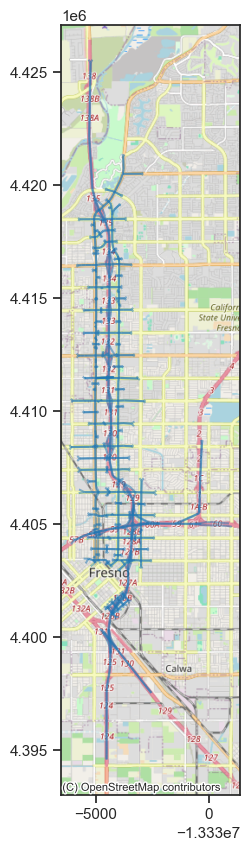

In [9]:
## Display network
links_gdf = gpd.read_file('./input/network-data/fresno/gis/links/fresno-links-gis.shp').set_crs(
        'EPSG:2228')
ax = links_gdf.to_crs(epsg=3857).plot(figsize=(10, 10), alpha=0.5)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

## Build Fresno network

In [10]:
network = build_network(links_df=links_df, nodes_df=nodes_df, crs='epsg:4326', key= 'fresno')

## Read OD matrix

In [11]:
read_OD(network=network, sparse=True)

q_historic = np.repeat(network.q.flatten()[np.newaxis, :], 6, axis=0)

Matrix Q (1789, 1789) read in 0.0[s] with sparse format
66266.3 trips were loaded among 6970 o-d pairs



## Read paths

In [12]:
#read_paths(network=network, update_incidence_matrices=True, filename = 'paths-full-model-fresno.csv')
read_paths(network=network, update_incidence_matrices=True, filename = 'paths-fresno-k3.csv')

20840 paths were read and incidence matrices were built


## Read spatiotemporal data

In [113]:
folderpath = './input/network-data/fresno/links/spatiotemporal-data/'
df = pd.concat([pd.read_csv(file) for file in glob.glob(folderpath + "*link-data*")], axis=0)

df['link_key'] = pd.Categorical(df['link_key'].apply(ast.literal_eval), list(network.links_dict.keys()))
df['period'] = pd.to_datetime(df['period'], format = '%Y-%m-%d-%H').dt.strftime('%Y-%m-%d-%H')
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
# Select data from Tuesday (1) to Thursday (3)
df = df[df['date'].dt.dayofweek.between(1, 3)]
# Select data from one day only in 2019 and 2020
# df = df[df['date'].isin(["2019-10-01", "2020-10-06"])]

In [114]:
# Add period id for timevarying estimation
period_feature = 'hour'

df = add_period_id(df, period_feature='hour')

period_keys = df[[period_feature,'period_id']].drop_duplicates().reset_index().drop('index',axis =1).sort_values('hour')
print(period_keys)

    hour  period_id
11     6          0
12     7          1
13     8          2
14     9          3
0     10          4
1     11          5
2     12          6
3     13          7
4     14          8
5     15          9
6     16         10
7     17         11
8     18         12
9     19         13
10    20         14


In [115]:
df.head()

,link_key,observed,counts,capacity [veh],tt_ff [min],speed_ff[mi/hr],inrix_id,pems_ids,link_type,id,...,median_age,incidents,bus_stops,intersections,date,hour,tf_inrix,year,period,period_id
0,"(0, 1621, 0)",0,NaN,1800.0,0.098,45,1.626616e+09,[],LWRLK,1,...,31.1,0,0,1,2019-10-01,10,0.221,2019,2019-10-01-10,4
1,"(1239, 1630, 0)",0,NaN,inf,0.000,99999,NaN,[],DMDLK,565,...,0.0,0,0,0,2019-10-01,10,0.000,2019,2019-10-01-10,4
2,"(228, 192, 0)",1,1667.0,2400.0,0.110,65,1.626659e+09,[602350],LWRLK,564,...,16.6,0,0,0,2019-10-01,10,0.112,2019,2019-10-01-10,4
3,"(1243, 1631, 0)",0,NaN,inf,0.000,99999,NaN,[],DMDLK,563,...,0.0,0,0,0,2019-10-01,10,0.000,2019,2019-10-01-10,4
4,"(1244, 1632, 0)",0,NaN,inf,0.000,99999,NaN,[],DMDLK,562,...,0.0,0,0,0,2019-10-01,10,0.000,2019,2019-10-01-10,4


In [116]:
# Units in miles per hour
df[['speed_ref_avg','speed_hist_avg','speed_max']].describe()

,speed_ref_avg,speed_hist_avg,speed_max
count,72390.000000,72123.000000,72390.000000
mean,18.767085,17.177355,20.169250
std,19.841366,19.064831,21.482367
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,19.884000,16.777000,20.505000
75%,26.719000,25.010000,31.069000
max,67.729000,73.943000,80.778000


In [117]:
df.columns

Index(['link_key', 'observed', 'counts', 'capacity [veh]', 'tt_ff [min]',
       'speed_ff[mi/hr]', 'inrix_id', 'pems_ids', 'link_type', 'id', 'rhoj',
       'lane', 'ff_speed', 'length', 'alpha', 'beta', 'tf', 'k', 'inrix_id.1',
       'speed_avg', 'speed_ref_avg', 'speed_hist_avg', 'tt_avg', 'speed_max',
       'speed_sd', 'speed_cv', 'speed_hist_sd', 'speed_ref_sd', 'tt_sd',
       'tt_var', 'tt_cv', 'road_closures', 'median_inc', 'median_age',
       'incidents', 'bus_stops', 'intersections', 'date', 'hour', 'tf_inrix',
       'year', 'period', 'period_id'],
      dtype='object')

## Data curation

In [118]:
df.loc[df['speed_ref_avg']<=0,'speed_ref_avg'] = float('nan')

df['tt_ff'] = np.where(df['link_type'] != 'LWRLK', 0,df['length']/df['speed_ref_avg'])
df.loc[(df.link_type == "LWRLK") & (df.speed_ref_avg == 0),'tt_ff'] = float('nan')

df['tt_avg'] = np.where(df['link_type'] != 'LWRLK', 0,df['length']/df['speed_hist_avg'])
df.loc[(df.link_type == "LWRLK") & (df.speed_hist_avg == 0),'tt_avg'] = float('nan')

tt_sd_adj = df.groupby(['period_id','link_key'])[['tt_avg']].std().reset_index().rename(columns = {'tt_avg': 'tt_sd_adj'})

df = df.merge(tt_sd_adj, on = ['period_id','link_key'])

df = data_curation(df)

df['tt_sd'] = df['tt_sd_adj']

In [119]:
# Units of travel time features are converted from hours to minutes
df['tt_sd'] = df['tt_sd']*60
df['tt_avg'] = df['tt_avg']*60
df['tt_ff'] = df['tt_ff']*60

In [120]:
df[['speed_ref_avg','speed_hist_avg', 'tt_ff', 'tt_avg','tt_sd_adj']].describe()

,speed_ref_avg,speed_hist_avg,tt_ff,tt_avg,tt_sd_adj
count,41790.000000,72123.000000,72390.000000,62403.000000,72390.000000
mean,32.508956,17.177355,0.204011,0.221042,0.000394
std,15.336469,19.064831,0.261289,0.266265,0.000685
min,8.078000,0.000000,0.000000,0.000000,0.000000
25%,22.991000,0.000000,0.000000,0.000000,0.000000
50%,26.719000,16.777000,0.150204,0.167558,0.000187
75%,34.175000,25.010000,0.279414,0.316023,0.000554
max,67.729000,73.943000,4.224682,3.827439,0.020323


## Node data

In [121]:
nodes_df = nodes_df.rename(columns ={'pop_tract':'population','stops_tract': 'bus_stops','median_inc':'income'})

In [122]:
features_generation = ['population','income', 'bus_stops']

nodes_df = nodes_df[['key','type'] + features_generation]

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(nodes_df[features_generation])
nodes_df[features_generation] = imp_mean.transform(nodes_df[features_generation])

scaler = preprocessing.StandardScaler().fit(nodes_df[features_generation].values)
# scaler = preprocessing.MinMaxScaler().fit(nodes_df[features_generation].values)
nodes_df[features_generation] = scaler.transform(nodes_df[features_generation].values)

## Utility function

In [123]:
_FEATURES_Z = ['tt_sd', 'median_inc', 'incidents', 'bus_stops', 'intersections']

## Data processing

In [124]:
n_links = len(network.links)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['year'] = df.date.dt.year
X, Y = {}, {}

In [125]:
df.query('year == 2019')[['counts', 'tt_ff', 'tt_avg', 'tf_inrix', 'tt_sd']].describe()

,counts,tt_ff,tt_avg,tf_inrix,tt_sd
count,2115.000000,36195.000000,30133.000000,36195.000000,36195.000000
mean,1770.335035,0.205374,0.225562,0.200966,0.023657
std,781.535783,0.262883,0.276121,0.228983,0.041103
min,46.000000,0.000000,0.000000,0.000000,0.000000
25%,1266.250000,0.000000,0.000000,0.000000,0.000000
50%,1689.000000,0.151343,0.170782,0.153000,0.011230
75%,2164.800000,0.281636,0.324932,0.280000,0.033246
max,4807.000000,4.224682,3.827439,2.113000,1.219398


In [126]:
df.query('year == 2020')[['counts', 'tt_ff', 'tt_avg', 'tf_inrix', 'tt_sd']].describe()

,counts,tt_ff,tt_avg,tf_inrix,tt_sd
count,2108.000000,36195.000000,32270.000000,36195.000000,36195.000000
mean,1581.200095,0.202649,0.216822,0.198494,0.023657
std,740.500890,0.259682,0.256653,0.226006,0.041103
min,16.000000,0.000000,0.000000,0.000000,0.000000
25%,1083.625000,0.000000,0.000000,0.000000,0.000000
50%,1509.000000,0.149437,0.165028,0.150000,0.011230
75%,1942.850000,0.274658,0.307113,0.273000,0.033246
max,4675.000000,4.224682,3.274444,2.113000,1.219398


In [127]:
# Set free flow travel times
tt_ff_links = df.groupby('link_key')['tt_ff'].min()
for link in network.links:
    network.links_dict[link.key].performance_function.tf = float(tt_ff_links[tt_ff_links.index==link.key].iloc[0])

In [128]:
# This correlation should be positive
df[['counts','tt_avg']].corr()

,counts,tt_avg
counts,1.000000,0.058501
tt_avg,0.058501,1.000000


## EDA

In [129]:
# To check that there is a balanced amount of observations per date
obs_date = df.groupby('date')['hour'].count()

In [130]:
# Stats by date
df.groupby('date')[['speed_sd','speed_avg', 'counts']].mean().assign(total_obs = obs_date)

,speed_sd,speed_avg,counts,total_obs
date,,,,
2019-10-01,1.731787,17.175187,1770.335035,36195
2020-10-06,1.365919,19.709670,1581.200095,36195


### Link attributes

In [131]:
df[_FEATURES_Z].describe()

,tt_sd,median_inc,incidents,bus_stops,intersections
count,72390.000000,72390.000000,72390.000000,72390.000000,72390.000000
mean,0.023657,26.219132,0.750311,0.150021,0.876502
std,0.041103,21.357520,3.200213,0.441196,1.319505
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.011230,24.821000,0.000000,0.000000,0.000000
75%,0.033246,41.681000,0.000000,0.000000,1.000000
max,1.219398,115.893000,40.000000,4.000000,9.000000


## Training and validation sets

In [132]:
_DTYPE = tf.float32

# Data between 4pm and 5pm to estimate LUE, ODLUE and ODLULPE models
X, Y = get_tensors_by_year(df[df.hour.isin([16])], features_Z = _FEATURES_Z,
                           links_keys=list(network.links_dict.keys()))

# Hourly data DURING morning and afternoon peak hour windows (6 hour intervals) to estimate TVODLULPE
XT, YT = get_tensors_by_year(df[df.hour.isin([6,7,8, 15,16,17])], features_Z = _FEATURES_Z,
                             links_keys=list(network.links_dict.keys()))

# Split in training and test sets
X_train, X_val, Y_train, Y_val = map(lambda x: tf.cast(x, dtype = _DTYPE), [X[2019], X[2020], Y[2019], Y[2020]])
XT_train, XT_val, YT_train, YT_val = map(lambda x: tf.cast(x, dtype = _DTYPE), [XT[2019], XT[2020], YT[2019], YT[2020]])

## Configuration

In [133]:
_LOSS_WEIGHTS ={'od': 0, 'traveltime': 1, 'flow': 1, 'equilibrium': 1}
# _LOSS_WEIGHTS ={'od': 0, 'traveltime': 0, 'flow': 1, 'equilibrium': 0}
_EQUILIBRIUM_STAGE = {'tvodlulpe': False, 'tvgodlulpe': True}
_LR = {'learning': 1e-1, 'equilibrium': 1e-1}
_RELATIVE_GAP = 1e-3 #5e-2
_BATCH_SIZE = 1
_EPOCHS = {'learning': 30, 'equilibrium': 30}
# _EPOCHS = {'learning': 3, 'equilibrium': 3}
_LOSS_METRIC  = z2score
_EVALUATION_METRIC = mdape
_OPTIMIZERS = {'learning': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['learning']),
              'equilibrium': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium'])
              }
_XTICKS_SPACING = 5

## Models

In [134]:
train_results_dfs = {}
val_results_dfs = {}
models = {}

In [135]:
def create_mlp(network, homogenous = False, diagonal = False, adjacency_constraint = True, poly_order = 4,
               alpha_prior = 0.15, beta_prior = 4, pretrain = False, dtype =_DTYPE, link_specific = True):

    return MLP(n_links=len(network.links),
               free_flow_traveltimes=[link.bpr.tf for link in network.links],
               capacities=[link.bpr.k for link in network.links],
               kernel_constraint=KernelConstraint(
                   link_keys=[(link.key[0], link.key[1]) for link in network.links],
                   dtype=dtype,
                   capacities=[link.bpr.k for link in network.links],
                   adjacency_constraint=adjacency_constraint,
                   free_flow_traveltimes=[link.bpr.tf for link in network.links],
                   diagonal= diagonal,
                   homogenous=homogenous,
                   bounds_clipping = [0,10],
                   min_diagonal_value = 1e-1
               ),
               trainable =True,
               polynomial_layer= PolynomialLayer(poly_order=poly_order,
                                                 trainable = True,
                                                 pretrain_weights=pretrain,
                                                 alpha_prior = alpha_prior, beta_prior=beta_prior,
                                                 kernel_constraint=tf.keras.constraints.NonNeg(),
                                                 link_specific = link_specific
                                                 ),
               alpha_relu = 0,
               depth=1,
               max_traveltime_factor = None,
               dtype=dtype)

def create_bpr(network, alpha_prior = 1, beta_prior = 1, dtype =_DTYPE):
    return BPR(keys=['alpha', 'beta'],
               initial_values={'alpha': alpha_prior * tf.ones(len(network.links), dtype = dtype),
                               'beta': beta_prior * tf.ones(len(network.links), dtype = dtype)},
               true_values={'alpha': 0.15, 'beta': 4},
               trainables={'alpha': True, 'beta':True},
               capacities = [link.bpr.k for link in network.links],
               free_flow_traveltimes =[link.bpr.tf for link in network.links],
               dtype = dtype
               )

def create_model(network, model_key = 'tvgodlulpe', dtype=_DTYPE, n_periods=1, features_Z=_FEATURES_Z, historic_g=None,
                                      performance_function=None, utility_parameters = None, od_parameters = None,
                                      generation_parameters = None, generation = True, od_trainable = False,
                                      utility_trainable = True, pretrain_generation_weights = True, generation_trainable = True):

    if utility_parameters is None:
        utility_parameters = UtilityParameters(features_Y=['tt'],
                                               features_Z=features_Z,
                                               initial_values={
                                                   'tt': -3.0597,
                                                   'tt_sd': -3.2678, 'median_inc': 0,
                                                   'incidents': -4.5368, 'bus_stops': 0, 'intersections': -3.8788,
                                                   'psc_factor': 0,
                                                   'fixed_effect': np.zeros_like(network.links)},

                                               signs={'tt': '-', 'tt_sd': '-', 'median_inc': '+', 'incidents': '-',
                                                      'bus_stops': '-', 'intersections': '-'},
                                               trainables={'psc_factor': False, 'fixed_effect': utility_trainable,
                                                           'tt': utility_trainable, 'tt_sd': True, 'median_inc': True,
                                                           'incidents': True,
                                                           'bus_stops': True, 'intersections': True
                                                           },
                                               time_varying=True,
                                               dtype=dtype
                                               )

    if performance_function is None:
        # performance_function = create_bpr(network = network, dtype = dtype)
        performance_function = create_mlp(network = network, dtype = dtype)

    if generation_parameters is None and generation:
        generation_parameters = GenerationParameters(
            features_Z=['population', 'income', 'bus_stops'],
            keys=['fixed_effect_od', 'fixed_effect_origin', 'fixed_effect_destination'],
            initial_values={'income': 0, 'population': 0, 'bus_stops': 0,
                            # 'fixed_effect': historic_g[0]
                            'fixed_effect': historic_g
                            },
            signs={'income': '+', 'population': '+', 'bus_stops': '-'},
            trainables={'fixed_effect': generation_trainable,
                        'income': False, 'population': False, 'bus_stops': False,
                        # 'income': True, 'population': True, 'bus_stops': True,
                        'fixed_effect_origin': False, 'fixed_effect_destination': False, 'fixed_effect_od': generation_trainable
                        },
            time_varying=True,
            historic_g= historic_g,
            pretrain_generation_weights=pretrain_generation_weights,
            dtype=dtype
        )

    if od_parameters is None:
        od_parameters = ODParameters(key='od',
                                     initial_values= q_historic,
                                     historic_values={10: network.q.flatten()},
                                     ods=network.ods,
                                     n_nodes = len(network.nodes),
                                     n_periods=n_periods,
                                     time_varying=True,
                                     trainable= od_trainable
                                     )

    model = NESUELOGIT(
        key=model_key,
        network=network,
        dtype=dtype,
        utility=utility_parameters,
        performance_function=performance_function,
        od=od_parameters,
        generation=generation_parameters,
        n_periods=n_periods
    )

    return model, {'utility_parameters': utility_parameters, 'generation_parameters': generation_parameters,
                   'od_parameters': od_parameters, 'performance_function': performance_function}

In [136]:
# Total trips tvodlulpe pesuelogit:
# Epoch 0: 6.6e+04 6.6e+04 6.6e+04 6.6e+04 6.6e+04 6.6e+04
# Final epoch: 6.4e+04 6.6e+04 6.3e+04 7.8e+04 7.9e+04 7.9e+04
# Growth factor captures the difference between the reference OD at epoch 0 and the estimated OD.
growth_factor = 7.9/6.6
#growth_factor = 1

generation_factors = compute_generation_factors(period_column=XT_train[:, :, -1, None].numpy(),
                                                              flow_column=YT_train[:,:,1, None].numpy(), reference_period=10)

n_periods = len(np.unique(XT_train[:, :, -1].numpy().flatten()))

generated_trips = growth_factor*generation_factors.values[:,np.newaxis]*compute_generated_trips(
    q = q_historic, ods= network.ods, n_nodes = len(network.nodes))

### Benchmark (TVODLULPE)

In [37]:

# To report runtime
t0 = time.time()

models['tvodlulpe'], _ = create_model(
    model_key = 'tvodlulpe',
    n_periods= n_periods, network = network,
    performance_function = create_bpr(network = network, dtype = _DTYPE, alpha_prior = 0.9327, beta_prior = 4.1017),
    od_parameters = ODParameters(key='od',
                                 #initial_values= generation_factors.values[:,np.newaxis]*tntp_network.q.flatten(),
                                 initial_values = tf.stack(q_historic),
                                 historic_values={10: q_historic[0].flatten()},
                                 ods=network.ods,
                                 n_nodes = len(network.nodes),
                                 n_periods=n_periods,
                                 time_varying=True,
                                 trainable=True),
    generation = False,
    utility_trainable = True
)

models['tvodlulpe'].key = 'tvodlulpe'

In [38]:
train_results_dfs['tvodlulpe'], val_results_dfs['tvodlulpe'] = models['tvodlulpe'].fit(
    XT_train, YT_train, XT_val, YT_val,
    optimizers= _OPTIMIZERS,
    node_data=nodes_df,
    batch_size=_BATCH_SIZE,
    loss_weights=_LOSS_WEIGHTS,
    loss_metric= _LOSS_METRIC,
    evaluation_metric = _EVALUATION_METRIC,
    equilibrium_stage=_EQUILIBRIUM_STAGE['tvodlulpe'],
    pretrain_link_flows = True,
    threshold_relative_gap=_RELATIVE_GAP,
    epochs=_EPOCHS)

print(f'runtime: {time.time()-t0:0.1f} [s]')

# Save model weights for prediction analyses
models['tvodlulpe'].save_weights(models['tvodlulpe']._filepath_weights)
print(f"\nModel weights were saved at '{models['tvodlulpe']._filepath_weights}'")


Model training

Link flows and travel times were pretrained with single pass of traffic assignment
Benchmark metrics using historical mean in training data to make predictions in the validation set: 


    component    value metric
0        flow       27  mdape
1  traveltime       41  mdape
0        flow    6e+05    mse
1  traveltime    0.063    mse
0        flow   -0.057     r2
1  traveltime -0.00022     r2

hyperparameters loss function: {'od': 0, 'traveltime': 1, 'flow': 1, 'equilibrium': 1}

number of periods: 6, batch size: 1, threshold relative gap: 0.01
training set -> timepoints: 90, obs [t x]: [2073.  140.], coverage [t x]: [0.86 0.06]
validation set -> timepoints: 78, obs [t x]: [2139.  140.], coverage [t x]: [0.89 0.06]

Learning stage: 30 epochs

0/30: train mse=6.8e+05, train mse traveltime=1.8, train mdape traveltime=15.1 train mse flow=1.9e+06, train mdape flow=48.6, val mse=8e+05, val mse traveltime=1.8, val mdape traveltime=14.1 val mse flow=2.3e+06, val mdape flow=53

In [39]:
metrics_df = models['tvodlulpe'].compute_loss_metrics(metrics={_EVALUATION_METRIC.__name__: _EVALUATION_METRIC, 'mse': mse, 'r2': r2_score},
                                                      X=XT_train, Y=YT_train).assign(dataset='training')
# metrics_df = pd.concat([metrics_df,
#                         models['tvodlulpe'].compute_loss_metrics(metrics={_EVALUATION_METRIC.__name__: _EVALUATION_METRIC, 'mse': mse, 'r2': r2_score},
#                                                                  X=XT_val, Y=YT_val).assign(dataset='validation'),
#                         compute_benchmark_metrics(metrics={_EVALUATION_METRIC.__name__: _EVALUATION_METRIC, 'mse': mse, 'r2': r2_score}, Y_ref=YT_train,
#                                                   Y=YT_val).assign(
#                             dataset='benchmark')
#                         ])

with pd.option_context('display.float_format', '{:0.3g}'.format):
    print(pd.pivot(metrics_df, index=['component', 'dataset'], columns=['metric'])['value'])


metric                mdape      mse    r2
component   dataset                       
equilibrium training    2.2 6.15e+03  0.99
flow        training   15.9  3.7e+05 0.393
traveltime  training   4.37  0.00253 0.962


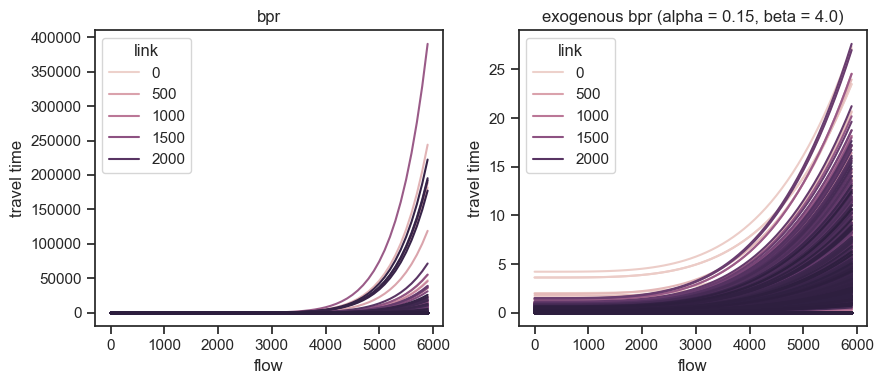

In [40]:
flow_range = range(0,6000,100)
sharey = False

fig, axs = plot_performance_functions(model = models['tvodlulpe'],
                                      network = network,
                                      marginal = False,
                                      #alpha=models['tvodlulpe'].performance_function.alpha,
                                      #beta=models['tvodlulpe'].performance_function.beta,
                                      alpha=0.15*np.ones(network.get_n_links()),
                                      beta=4*np.ones(network.get_n_links()),
                                      sharey = sharey,
                                      flow_range = flow_range
                                      # selected_links = np.random.choice(range(tntp_network.get_n_links()), 10, replace=False)
                                      )

# for ax in axs.reshape(-1):
#     ax.set_xlim(xmin=-10)
#     ax.set_ylim(ymin=-1)
#     ax.legend(loc='upper left', title = 'link')

plt.savefig('output/figures/results/fresno-comparison-all-link-performance-functions-tvodlulpe.png')

plt.show()

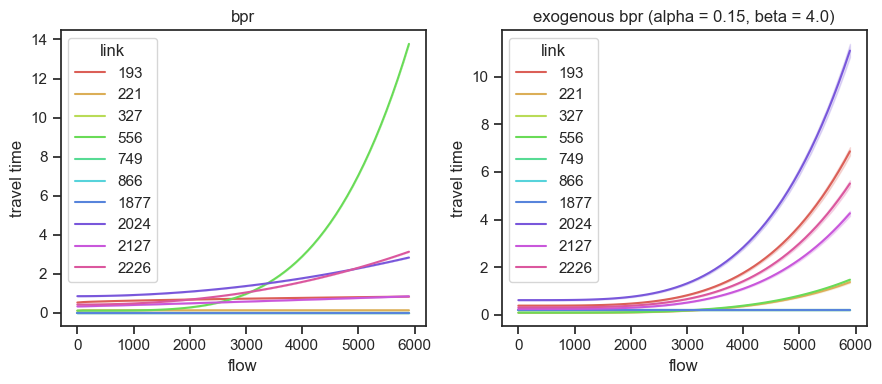

In [41]:
selected_links = np.random.choice(range(network.get_n_links()), 10, replace=False)

plot_performance_functions(model=models['tvodlulpe'],
                           network=network,
                           marginal=True,
                           # alpha=models['tvodlulpe'].performance_function.alpha,
                           # beta=models['tvodlulpe'].performance_function.beta,
                           alpha=0.15*np.ones(network.get_n_links()),
                           beta=4*np.ones(network.get_n_links()),
                           selected_links = selected_links,
                           palette = sns.color_palette("hls", len(selected_links)),
                           sharey = sharey,
                           flow_range = flow_range
                           )

plt.show()

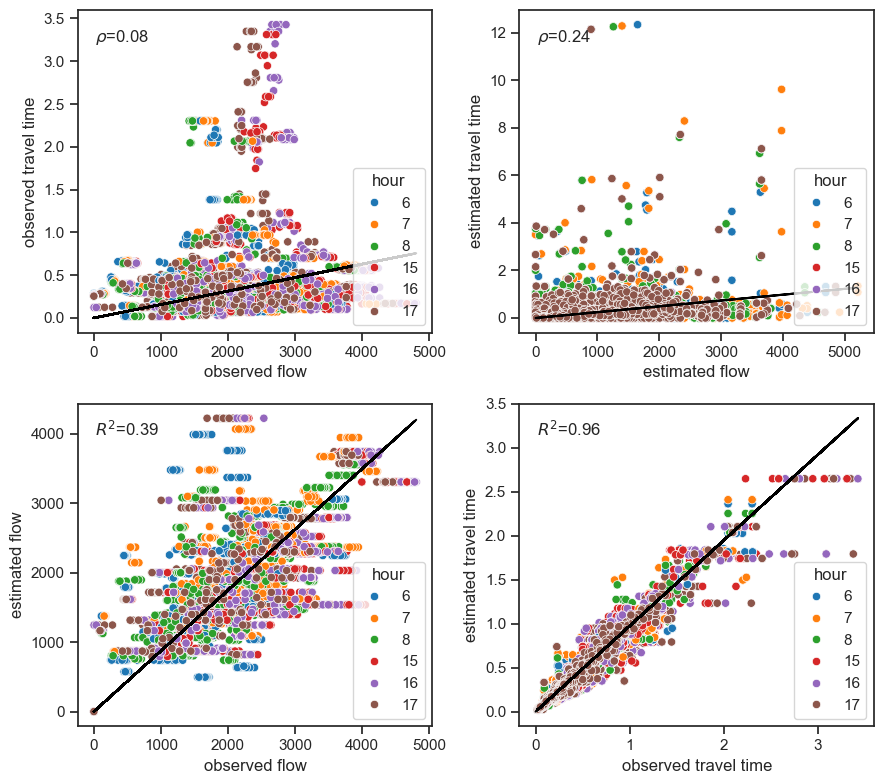

In [42]:
fig, axs = plot_flow_vs_traveltime(model = models['tvodlulpe'],
                        observed_traveltime=models['tvodlulpe'].mask_observed_traveltime(YT_train[:, :, 0]),
                        observed_flow= models['tvodlulpe'].mask_observed_flow(YT_train[:,:,1]),
                        period_col = pd.DataFrame({'period': list(XT_train[:, :, -1].numpy().astype(int).flatten())})['period'].map(dict(zip(period_keys.period_id, period_keys.hour))).values.flatten(),
                        hour_label=True,
                        # scatter_kws={"color": sns.color_palette("deep")[0], 's':4, 'alpha': 1}, line_kws={"color": "black"},
                        all_metrics = False
                        )

for ax in axs.reshape(-1):
    ax.legend(loc='lower right', title = 'hour')

plt.show()

(<Figure size 550x500 with 1 Axes>, <Axes: xlabel='epoch', ylabel='mdape (%)'>)

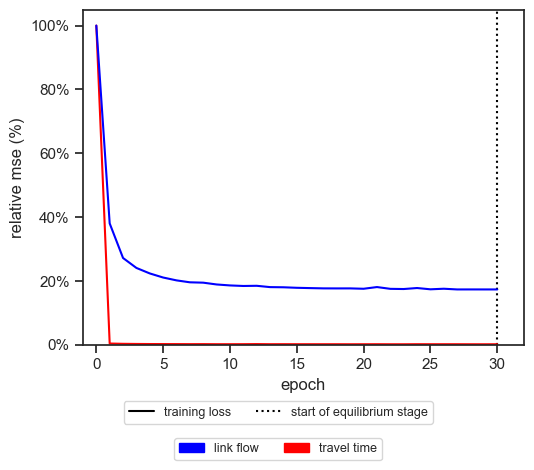

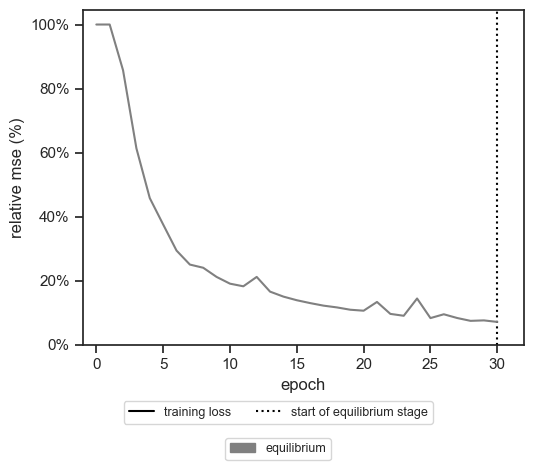

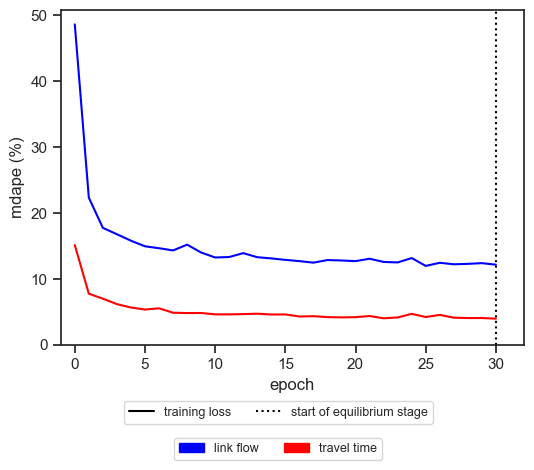

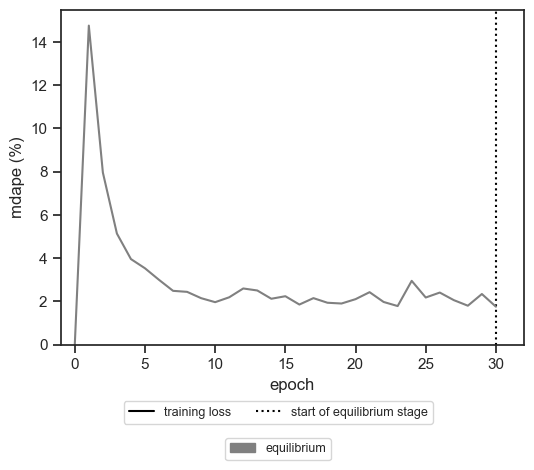

In [43]:
plot_predictive_performance(train_losses=train_results_dfs['tvodlulpe'], val_losses=val_results_dfs['tvodlulpe'],
                            xticks_spacing=_XTICKS_SPACING, show_validation=False,
                            # curves=['travel time', 'link flow'],
                            curves=['travel time', 'link flow'],
                            epochs_end_learning_stage = _EPOCHS['learning']
                            )

plt.savefig('output/figures/results/fresno-relative-mse-tvodlulpe.png')

plot_predictive_performance(train_losses=train_results_dfs['tvodlulpe'], val_losses=val_results_dfs['tvodlulpe'],
                            xticks_spacing=_XTICKS_SPACING, show_validation=False,
                            curves=['equilibrium'],
                            epochs_end_learning_stage=_EPOCHS['learning'])

plot_predictive_performance(train_losses=train_results_dfs['tvodlulpe'], val_losses=val_results_dfs['tvodlulpe'],
                            xticks_spacing=_XTICKS_SPACING, show_validation=False,
                            curves=['travel time', 'link flow'],
                            epochs_end_learning_stage=_EPOCHS['learning'], prefix_metric=_EVALUATION_METRIC.__name__,
                            yaxis_label=f'{_EVALUATION_METRIC.__name__} (%)')

plt.savefig(f'output/figures/results/fresno-{_EVALUATION_METRIC.__name__}-tvodlulpe.png')

plot_predictive_performance(train_losses=train_results_dfs['tvodlulpe'], val_losses=val_results_dfs['tvodlulpe'],
                            xticks_spacing=_XTICKS_SPACING, show_validation=False,
                            curves=['equilibrium'],
                            epochs_end_learning_stage=_EPOCHS['learning'], prefix_metric=_EVALUATION_METRIC.__name__,
                            yaxis_label=f'{_EVALUATION_METRIC.__name__} (%)')

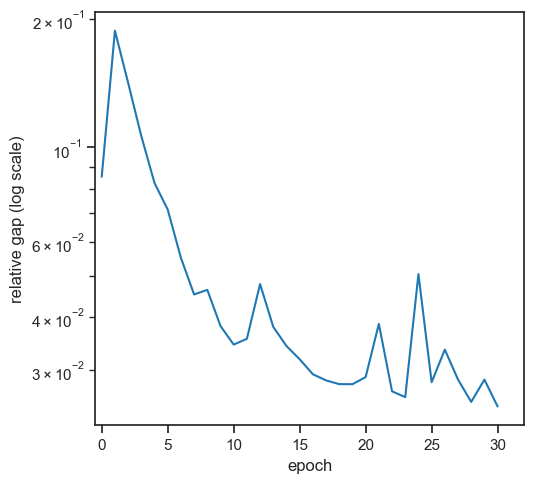

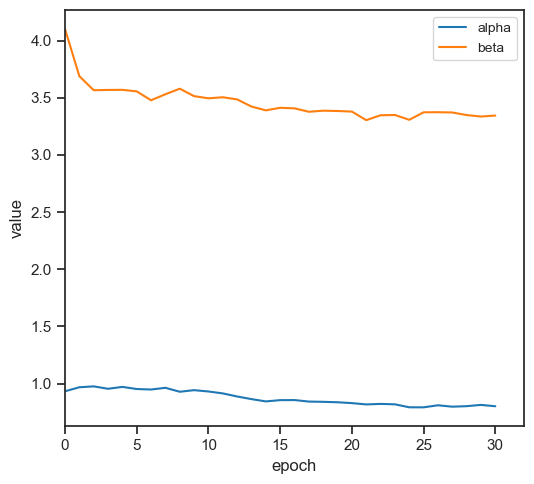

In [44]:
fig, ax = plot_convergence_estimates(
    estimates=train_results_dfs['tvodlulpe'].assign(
        relative_gap=np.abs(train_results_dfs['tvodlulpe']['relative_gap']))[['epoch', 'relative_gap']],
    xticks_spacing=_XTICKS_SPACING)

#ax.set_ylim(ymin=1e-2, ymax = 5.5e-2)
#ax.set_ylim(ymin=1e-2)
ax.set_xlim(xmin=-0.5)
ax.set_yscale('log')
ax.set_ylabel('relative gap (log scale)')
ax.get_legend().remove()

plt.savefig('output/figures/results/fresno-relative-gap-tvodlulpe.png')

plt.show()

plot_convergence_estimates(estimates=train_results_dfs['tvodlulpe'][['epoch', 'alpha', 'beta']],
                           xticks_spacing=_XTICKS_SPACING)
plt.show()

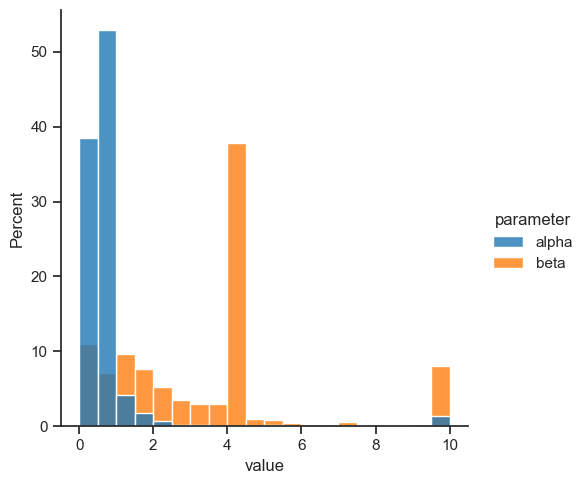

             tt     tt_sd  median_inc  incidents  bus_stops  intersections  \
6-7   -3.904516 -4.248691    0.014970  -4.712103  -1.413453      -4.032183   
7-8   -3.253996 -1.317837    0.000000  -2.729821   0.000000      -4.517776   
8-9   -3.256557 -3.158862    0.305639  -4.529685   0.000000      -2.870616   
15-16 -2.645367 -3.236387    0.377525  -5.035968   0.000000      -3.268593   
16-17 -3.361023 -3.402560    0.000000  -5.766107   0.000000      -3.783950   
17-18 -5.482796 -2.258352    0.000000  -6.348699   0.000000      -1.928216   

       hour  
6-7       6  
7-8       7  
8-9       8  
15-16    15  
16-17    16  
17-18    17  


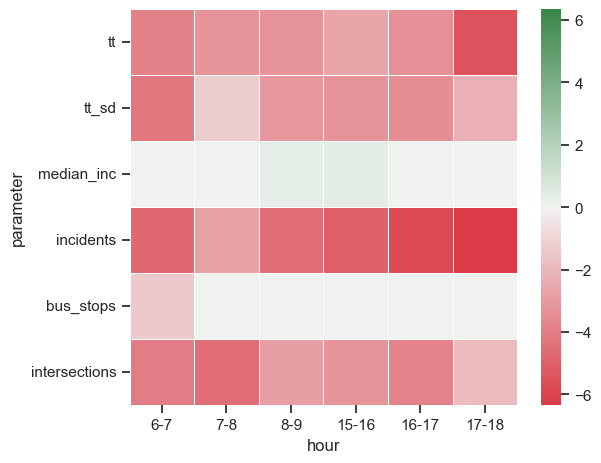

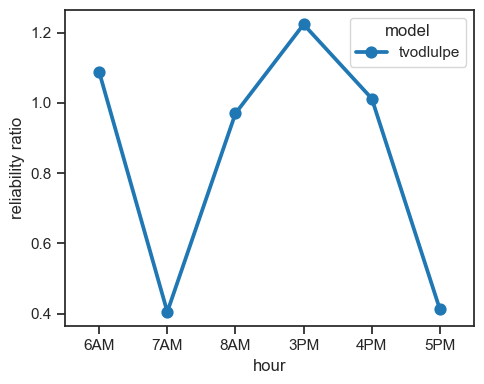

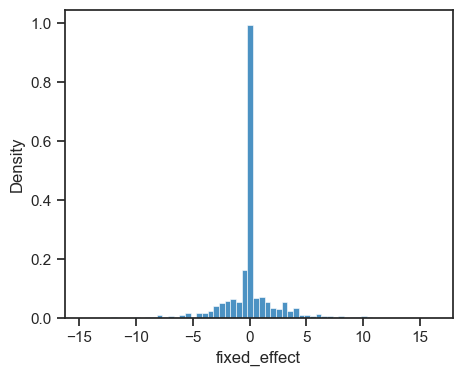

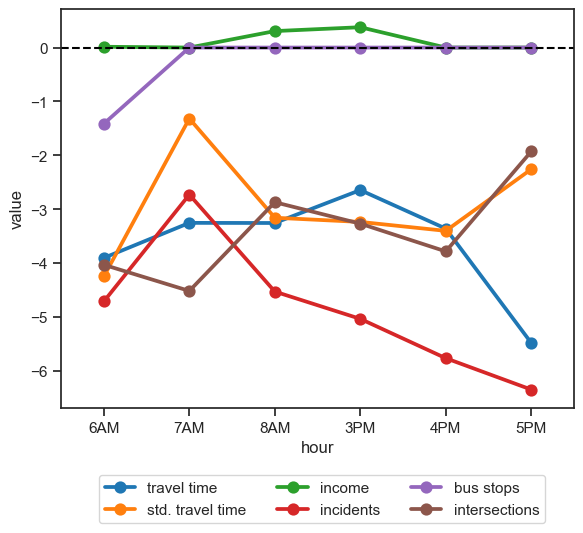

In [45]:
#sns.displot(plot_data, x="value", hue="parameter", multiple="stack", kind="hist", alpha=0.8, norm_hist=True)

plot_data = pd.melt(pd.DataFrame({'alpha': models['tvodlulpe'].performance_function.alpha,
                              'beta': models['tvodlulpe'].performance_function.beta}), var_name='parameter')

# fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (5,4))
# sns.histplot(plot_data, x="value", stat='density', hue="parameter", alpha =0.8, ax = ax, binwidth = 0.5)

sns.displot(plot_data, x="value", kind="hist", stat='percent', common_norm=False, hue = "parameter", alpha=0.8, facet_kws=dict(sharey=False, sharex = False), binwidth = 0.5)

plt.savefig('output/figures/results/fresno-distribution-link-performance-parameters-tvodlulpe.png')

plt.show()

# Compute utility parameters over time (heatmap) and value of travel time reliability (lineplot)
theta_df = plot_utility_parameters_periods(models['tvodlulpe'], period_keys = period_keys, period_feature='hour')

print(theta_df)
#print(theta_df.values)

plot_rr_by_period(models['tvodlulpe'],period_keys, model_key = 'tvodlulpe', period_feature='hour')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (5,4))
sns.histplot(pd.DataFrame({'fixed_effect': np.array(models['tvodlulpe'].fixed_effect)}), stat='density', x="fixed_effect", alpha=0.8, ax = ax, binwidth=0.5)
plt.show()

theta_df = plot_utility_parameters_periods(models['tvodlulpe'], period_keys=period_keys, period_feature='hour', plot = False).reset_index().\
    drop(['hour','index'], axis = 1).reset_index().rename(columns = {'index':'period'})

# theta_df = pd.melt(theta_df.assign(rr = theta_df.apply(compute_rr, axis=1)), id_vars = 'period', var_name = 'parameter').assign(group = 'utility').\
#     replace({'tt': 'travel time', 'tt_sd': 'std. travel time', 'rr': 'reliability ratio', 's': 'intersections', 'bus_stops': 'bus stops', 'median_inc': 'income'})

theta_df = pd.melt(theta_df, id_vars = 'period', var_name = 'parameter').assign(group = 'utility').\
    replace({'tt': 'travel time', 'tt_sd': 'std. travel time', 'rr': 'reliability ratio', 's': 'intersections', 'bus_stops': 'bus stops', 'median_inc': 'income'})

theta_df['hour'] = theta_df['period'].map({v:period_keys[period_keys.period_id == k]['hour'].iloc[0] for k,v in models['tvodlulpe'].period_dict.items()})

fig, axs = plot_parameters(df = theta_df, n_cols_legend = 3, figsize = (6,5.5), hour_label = True)

plt.axhline(0, linestyle ='dashed', color = 'black')

plt.savefig('output/figures/results/fresno-utility-periods-tvodlulpe.png')

plt.show()

/Users/pablo/github/nesuelogit/src/nesuelogit/visualizations.py:801: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  g = sns.pointplot(data=total_trips_by_hour, x=period_feature, y='total_trips', ax=ax,


(           historic_od          6AM          7AM          8AM         3PM  \
 1618 175     1840.4001  1740.571899  1002.102844  1051.847656  907.612061   
      694     1182.4533  1105.773071   620.937378   423.711639  429.961700   
 42   1617    1139.6952   334.416351   582.969788   386.865448  452.710327   
 693  1617    1077.8859   320.231598   507.999542   354.256073  398.812378   
 272  1614     598.5315     4.507037     8.823049     8.927793    0.858410   
 701  1629     577.9746   458.842712   274.455170   232.816498  268.211395   
 226  1651     472.3362   467.324402   510.376434   545.498840  470.604736   
 220  1688     446.1534   366.550476   299.639771   183.921829  356.706635   
 104  1693     430.1766   287.880676   218.154770   203.092590  403.026031   
 871  1679     428.9796   385.204254   325.526276   126.239105  402.394775   
 1615 88       426.7179     0.097279     0.024930     0.000992    0.000013   
 807  1650     418.2822   284.533417   243.718216   271.841461  

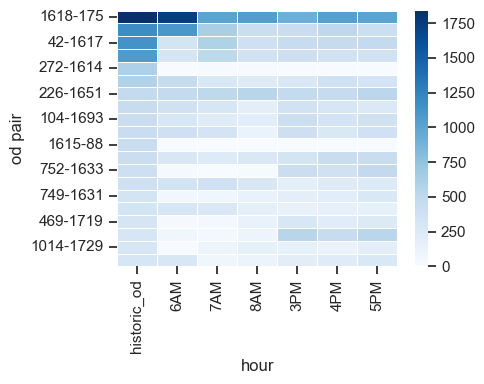

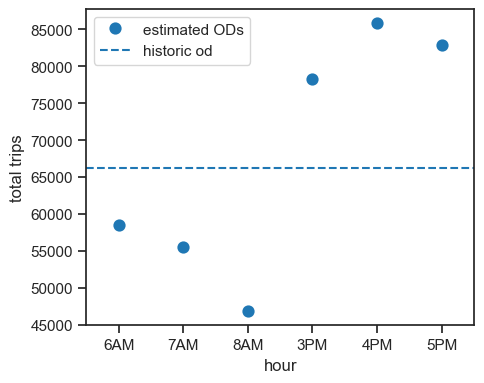

In [46]:
# Plot heatmap with flows of top od pairs
plot_top_od_flows_periods(models['tvodlulpe'],
                          historic_od= network.q.flatten(),
                          period_keys = period_keys,
                          period_feature='hour', top_k=20)

In [47]:
print(f"theta = "
      f"{dict(zip(models['tvodlulpe'].utility.true_values.keys(), list(np.mean(models['tvodlulpe'].theta.numpy(), axis=0))))}")

print(f"alpha = {np.mean(models['tvodlulpe'].performance_function.alpha): 0.2f}, "
          f"beta  = {np.mean(models['tvodlulpe'].performance_function.beta): 0.2f}")

print(f"Avg abs diff of observed and estimated OD: "
      f"{np.mean(np.abs(models['tvodlulpe'].q - network.q.flatten())): 0.2f}")

print(f"Avg observed OD: {np.mean(np.abs(network.q.flatten())): 0.2f}")

theta = {'tt': -3.650709, 'tt_sd': -2.9371147, 'median_inc': 0.116355576, 'incidents': -4.8537307, 'bus_stops': -0.23557557, 'intersections': -3.400222}
alpha =  0.80, beta  =  3.34
Avg abs diff of observed and estimated OD:  10.72
Avg observed OD:  9.51


### TVGODLULPE

In [48]:
print('\ntvgodlulpe: Time specific utility and generation, and link specific parameters for performance functions')

# To report runtime
t0 = time.time()

def create_tvgodlulpe_model():
    return create_model(
        n_periods = n_periods,
        network = network,
        performance_function = create_mlp(network = network,
                                          poly_order = 4, pretrain = False, link_specific = False),
        historic_g= generated_trips,
        generation = True,
        generation_trainable = True,
        utility_trainable = True)

models['tvgodlulpe'], _ = create_tvgodlulpe_model()
models['tvgodlulpe'].key = 'tvgodlulpe'


tvgodlulpe: Time specific utility and generation, and link specific parameters for performance functions


In [ ]:
train_results_dfs['tvgodlulpe'], val_results_dfs['tvgodlulpe'] = models['tvgodlulpe'].fit(
    XT_train, YT_train, XT_val, YT_val,
    node_data=nodes_df,
    optimizers= _OPTIMIZERS,
    batch_size=_BATCH_SIZE,
    # batch_size=None,
    loss_weights= _LOSS_WEIGHTS,
    loss_metric=_LOSS_METRIC,
    evaluation_metric = _EVALUATION_METRIC,
    equilibrium_stage=_EQUILIBRIUM_STAGE['tvgodlulpe'],
    pretrain_link_flows = True,
    threshold_relative_gap=_RELATIVE_GAP,
    epochs=_EPOCHS)

print(f'runtime: {time.time()-t0:0.1f} [s]')

# Save model weights for prediction analyses
models['tvgodlulpe'].save_weights(models['tvgodlulpe']._filepath_weights)
print(f"\nModel weights were saved at '{models['tvgodlulpe']._filepath_weights}'")


Model training

Pretraining generation weights

period 0 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 1 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 2 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 3 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 4 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 5 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}

Link flows and travel times were pretrained with single pass of traffic assignment
Benchmark metrics using historical mean in training data to make predictions in the validation set: 


    component    value metric
0        flow       27  mdape
1  traveltime       41  mdape
0        flow    6e+05    mse
1  traveltime    0.063    mse
0        flow   -0.057     r2
1  traveltime -0.00022     r2

hyperparameters los

In [98]:
metrics_df = models['tvgodlulpe'].compute_loss_metrics(metrics={_EVALUATION_METRIC.__name__: _EVALUATION_METRIC, 'mse': mse, 'r2': r2_score},
                                                      X=XT_train, Y=YT_train).assign(dataset='training')
# metrics_df = pd.concat([metrics_df,
#                         models['tvgodlulpe'].compute_loss_metrics(metrics={_EVALUATION_METRIC.__name__: _EVALUATION_METRIC, 'mse': mse, 'r2': r2_score},
#                                                                  X=XT_val, Y=YT_val).assign(dataset='validation'),
#                         compute_benchmark_metrics(metrics={_EVALUATION_METRIC.__name__: _EVALUATION_METRIC, 'mse': mse, 'r2': r2_score}, Y_ref=YT_train,
#                                                   Y=YT_val).assign(
#                             dataset='benchmark')
#                         ])

with pd.option_context('display.float_format', '{:0.3g}'.format):
    print(pd.pivot(metrics_df, index=['component', 'dataset'], columns=['metric'])['value'])
print(f'runtime: {time.time()-t0:0.1f} [s]')

metric                mdape      mse     r2
component   dataset                        
equilibrium training  0.726      430  0.999
flow        training   19.2 5.87e+05 0.0379
traveltime  training   8.53  0.00917  0.861
runtime: 35794.5 [s]


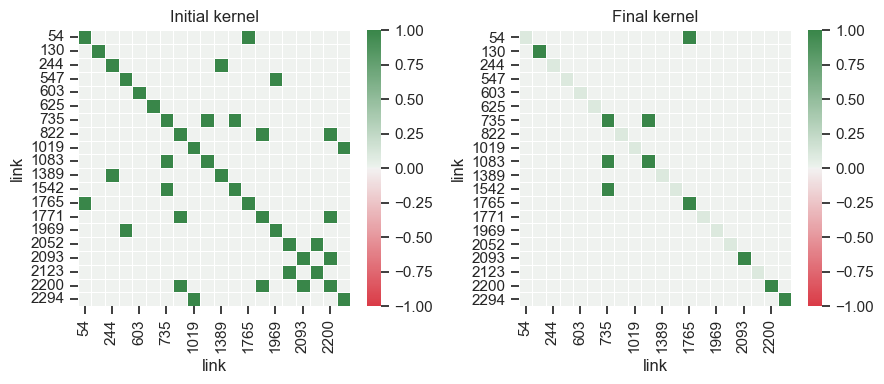

Final weights interaction:
 [[ 0.1     0.      0.     ...  0.      0.      0.    ]
 [ 0.     10.      8.1316 ...  0.      0.      0.    ]
 [ 0.     10.     10.     ...  0.      0.      0.    ]
 ...
 [ 0.      0.      0.     ...  0.1     0.      0.    ]
 [ 0.      0.      0.     ...  0.      0.1     0.    ]
 [ 0.      0.      0.     ...  0.      0.      1.    ]]

Initial weights interaction:
 [[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [99]:
selected_links = np.random.choice(range(network.get_n_links()), 20, replace=False)

#weights_interaction = models['tvgodlulpe'].performance_function.weights[1].numpy()
weights_interaction = models['tvgodlulpe'].performance_function.model.layers[0].kernel_matrix.numpy()
initial_weights_interaction = models['tvgodlulpe'].performance_function.kernel_constraint.initial_values.numpy()
# Plot sign of values in flow interaction matrix
plot_flow_interaction_matrix(
    flow_interaction_matrix=weights_interaction,
    masking_matrix = initial_weights_interaction,
    # flow_interaction_matrix=np.where(weights_interaction>0, 1, -1)*np.where(weights_interaction==0, 0, 1),
    # masking_matrix = np.where(initial_weights_interaction>0, 1, -1)*np.where(initial_weights_interaction==0, 0, 1),
    links_ids = selected_links + 1,
    # vmin = -0.05, vmax = 0.05
    vmin = -1, vmax = 1
)

plt.savefig('output/figures/results/fresno-kernel-link-performance-functions-tvgodlulpe.png')

plt.show()

print(f'Final weights interaction:\n {weights_interaction}')
print(f'\nInitial weights interaction:\n',initial_weights_interaction)

# non_diagonal_mlp_weights = weights[~np.eye(weights.shape[0], dtype=bool)]
# print(f"Percentage of non-diagonal terms that are non-positive: {len(non_diagonal_mlp_weights[(non_diagonal_mlp_weights<=0)])/len(non_diagonal_mlp_weights):.2%}")

# non_zero_elements = weights_interaction[np.where(models['tvgodlulpe'].performance_function.kernel_constraint.initial_values.numpy()>0)]
# print(f"Percentage of non-zero terms that are positive: {len(non_zero_elements[(non_zero_elements>0)])/len(non_zero_elements):.2%}")

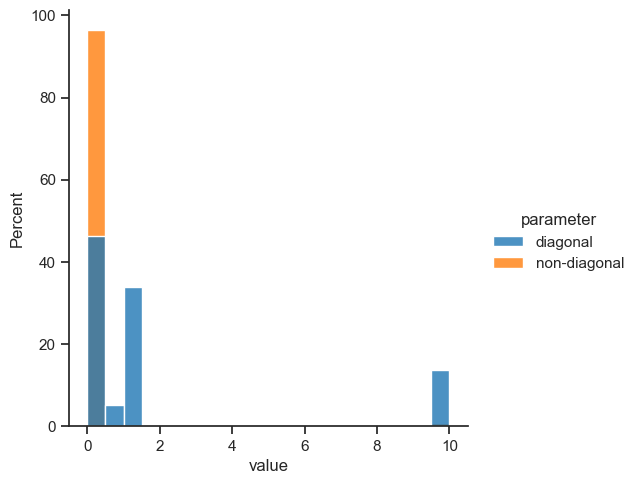

                 value  value_abs
parameter                        
diagonal      1.846420   1.846420
non-diagonal  0.210037   0.210037
              value
parameter          
diagonal       2413
non-diagonal  12314


In [100]:
# Distribution of weight in interaction flow matrix. Elements that are set to zero by default are excluded from non-diagonal
plot_data = pd.concat([pd.DataFrame({'value': tf.linalg.diag_part(weights_interaction).numpy().flatten(), 'parameter': 'diagonal'}),
                                  pd.DataFrame({'value': weights_interaction[np.where(~np.eye(weights_interaction.shape[0],dtype=bool)*models['tvgodlulpe'].performance_function.kernel_constraint.adjacency_constraint_matrix)], 'parameter': 'non-diagonal'})])

sns.displot(data = plot_data, x="value", kind="hist", stat='percent', common_norm=False, hue = "parameter", alpha=0.8,
            facet_kws=dict(sharey=False, sharex = False), binwidth = 0.5) # , col="parameter"

plt.savefig('output/figures/results/fresno-distribution-link-performance-parameters-tvgodlulpe.png')

plt.show()

plot_data['value_abs'] = plot_data.value.abs()

print(plot_data.groupby('parameter')[['value', 'value_abs']].mean())
print(plot_data.groupby('parameter')[['value']].count())

In [101]:
# Weight of polynomial
print(f"polynomial weights {tf.reduce_mean(models['tvgodlulpe'].performance_function.polynomial_layer.poly_weights,0).numpy()}")

polynomial weights [0.022  0.012  0.0108 0.0104]


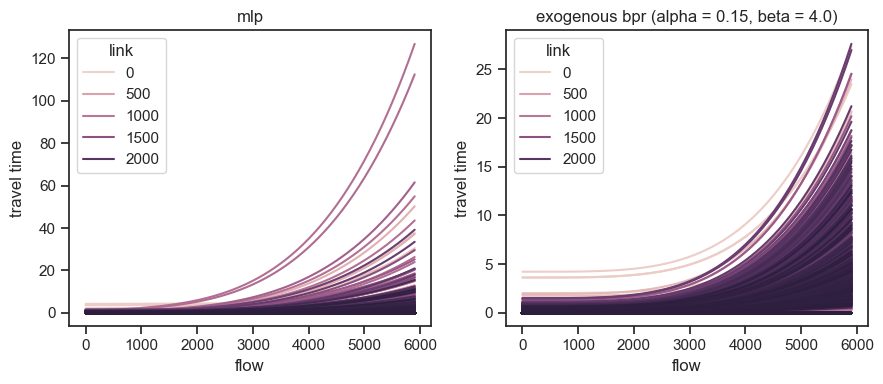

In [102]:
flow_range = range(0,6000,100)
sharey = False

plot_performance_functions(model = models['tvgodlulpe'],
                           network = network,
                           marginal = False,
                           alpha= 0.15, #models['tvodlulpe'].performance_function.alpha,
                           beta= 4, #models['tvodlulpe'].performance_function.beta,
                           sharey = sharey,
                           flow_range = flow_range
                           )

plt.savefig('output/figures/results/fresno-comparison-all-link-performance-functions-tvgodlulpe.png')

plt.show()

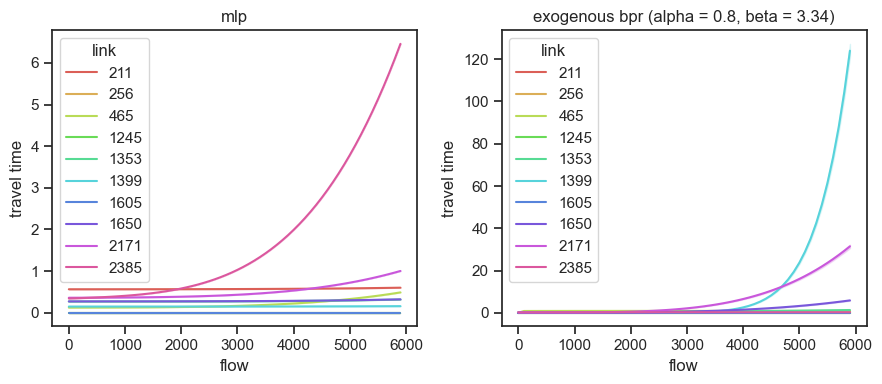

In [103]:
selected_links = np.random.choice(range(network.get_n_links()), 10, replace=False)

plot_performance_functions(model = models['tvgodlulpe'],
                           network = network,
                           marginal = True,
                           selected_links = selected_links,
                           # alpha = 0.15*np.ones(network.get_n_links()),
                           # beta = 4*np.ones(network.get_n_links()),
                           alpha=models['tvodlulpe'].performance_function.alpha,
                           beta=models['tvodlulpe'].performance_function.beta,
                           palette = sns.color_palette("hls", len(selected_links)),
                           sharey = sharey,
                           flow_range = flow_range
                           )
plt.show()

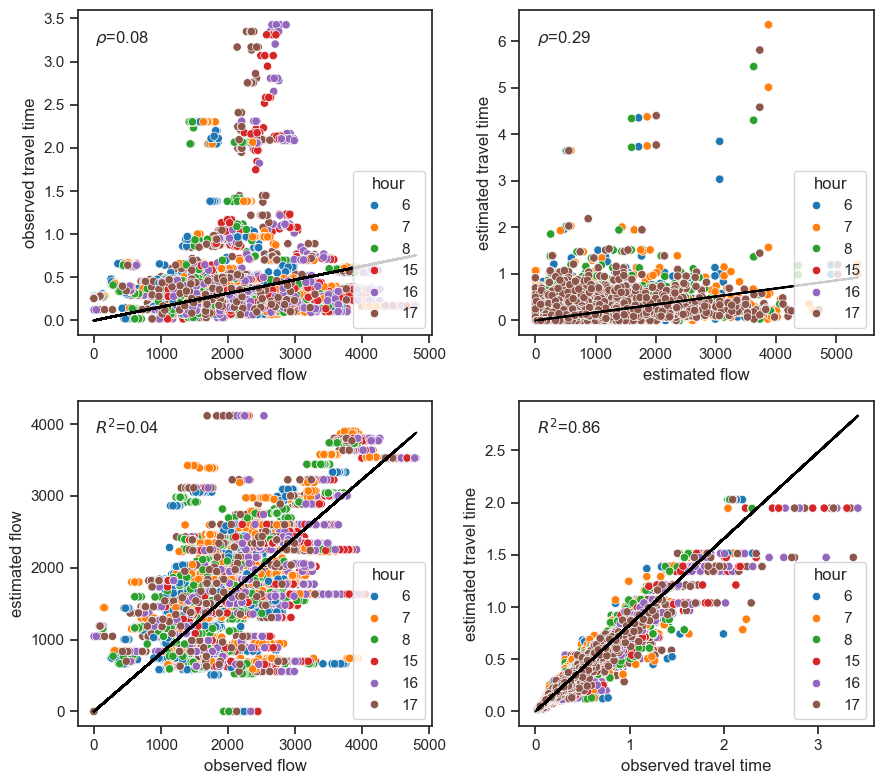

In [104]:
fig, axs = plot_flow_vs_traveltime(model = models['tvgodlulpe'],
                        observed_traveltime=models['tvgodlulpe'].mask_observed_traveltime(YT_train[:, :, 0]),
                        observed_flow= models['tvgodlulpe'].mask_observed_flow(YT_train[:,:,1]),
                        period_col = pd.DataFrame({'period': list(XT_train[:, :, -1].numpy().astype(int).flatten())})['period'].map(dict(zip(period_keys.period_id, period_keys.hour))).values.flatten(),
                        hour_label=True,
                        all_metrics = False
                        )

for ax in axs.reshape(-1):
    ax.legend(loc='lower right', title = 'hour')

plt.savefig('output/figures/results/fresno-scatter-flow-traveltime-tvgodlulpe.png')

plt.show()

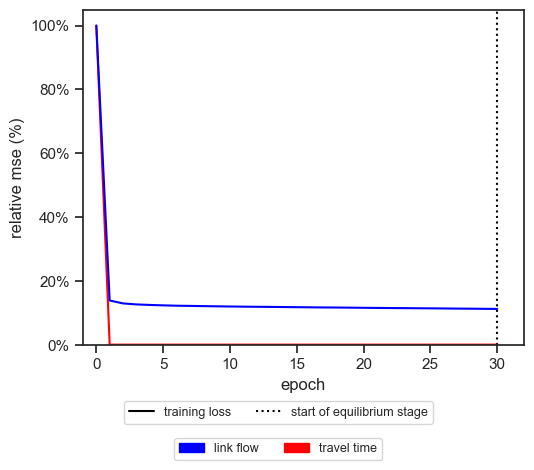

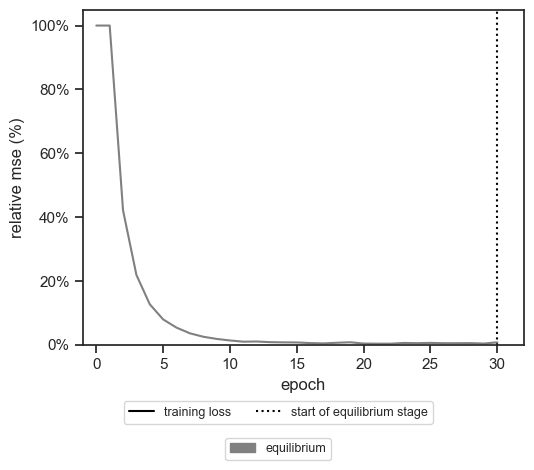

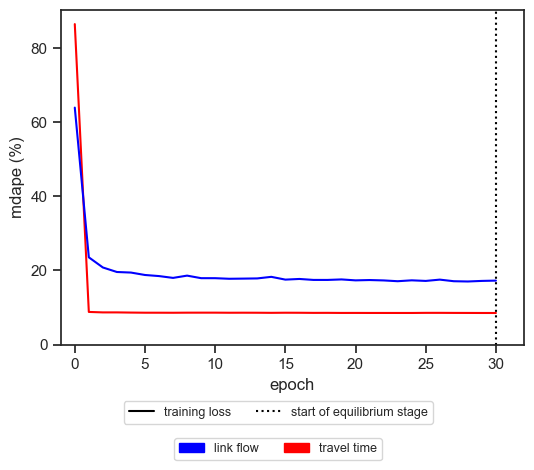

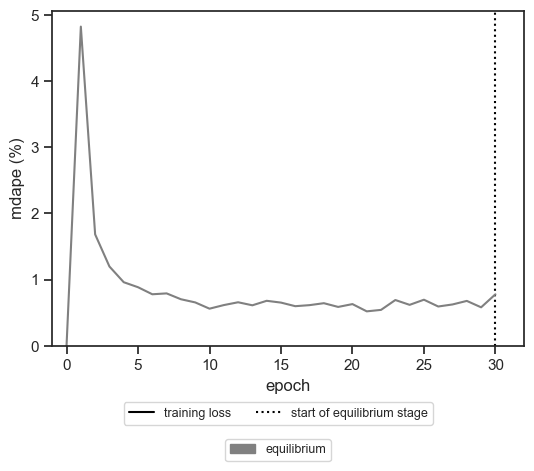

In [105]:
plot_predictive_performance(train_losses=train_results_dfs['tvgodlulpe'], val_losses=val_results_dfs['tvgodlulpe'],
                            xticks_spacing=_XTICKS_SPACING, show_validation=False,
                            # curves=['travel time', 'link flow'],
                            curves=['travel time', 'link flow'],
                            epochs_end_learning_stage = _EPOCHS['learning']
                            )

plt.savefig('output/figures/results/fresno-relative-mse-tvgodlulpe.png')

plot_predictive_performance(train_losses=train_results_dfs['tvgodlulpe'], val_losses=val_results_dfs['tvgodlulpe'],
                            xticks_spacing=_XTICKS_SPACING, show_validation=False,
                            curves=['equilibrium'],
                            epochs_end_learning_stage=_EPOCHS['learning'])

plot_predictive_performance(train_losses=train_results_dfs['tvgodlulpe'], val_losses=val_results_dfs['tvgodlulpe'],
                            xticks_spacing=_XTICKS_SPACING, show_validation=False,
                            curves=['travel time', 'link flow'],
                            epochs_end_learning_stage=_EPOCHS['learning'], prefix_metric=_EVALUATION_METRIC.__name__,
                            yaxis_label=f'{_EVALUATION_METRIC.__name__} (%)')

plt.savefig(f'output/figures/results/fresno-{_EVALUATION_METRIC.__name__}-tvgodlulpe.png')

plot_predictive_performance(train_losses=train_results_dfs['tvgodlulpe'], val_losses=val_results_dfs['tvgodlulpe'],
                            xticks_spacing=_XTICKS_SPACING, show_validation=False,
                            curves=['equilibrium'],
                            epochs_end_learning_stage=_EPOCHS['learning'], prefix_metric=_EVALUATION_METRIC.__name__,
                            yaxis_label=f'{_EVALUATION_METRIC.__name__} (%)')


plt.show()

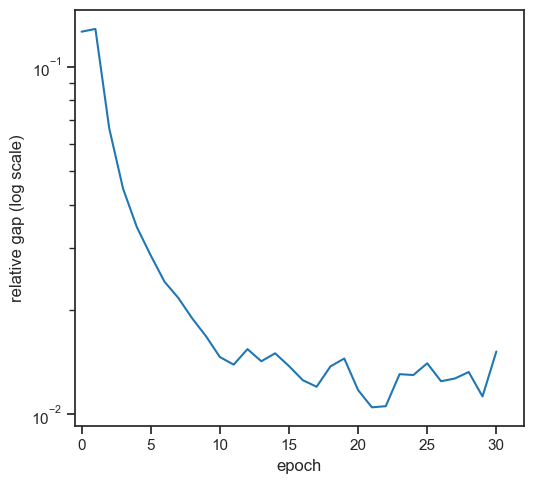

In [106]:
fig, ax = plot_convergence_estimates(
    estimates=train_results_dfs['tvgodlulpe'].assign(
        relative_gap=np.abs(train_results_dfs['tvgodlulpe']['relative_gap']))[['epoch', 'relative_gap']],
    xticks_spacing=_XTICKS_SPACING)

#ax.set_ylim(ymin=1e-2)
# ax.set_ylim(ymin=1e-2, ymax = 5.5e-2)
ax.set_xlim(xmin=-0.5)
ax.set_yscale('log')
ax.set_ylabel('relative gap (log scale)')
ax.get_legend().remove()

plt.savefig('output/figures/results/fresno-relative-gap-tvgodlulpe.png')

plt.show()

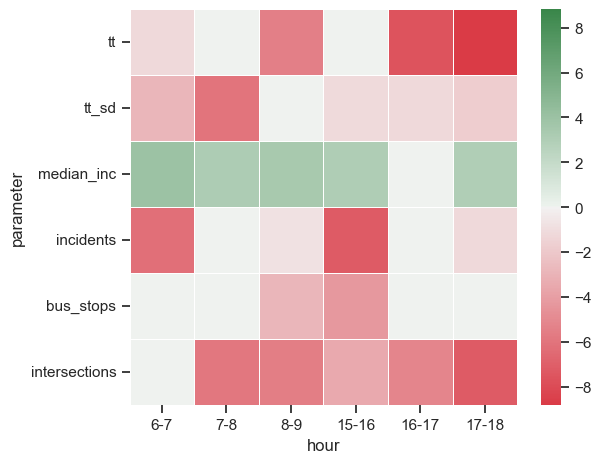

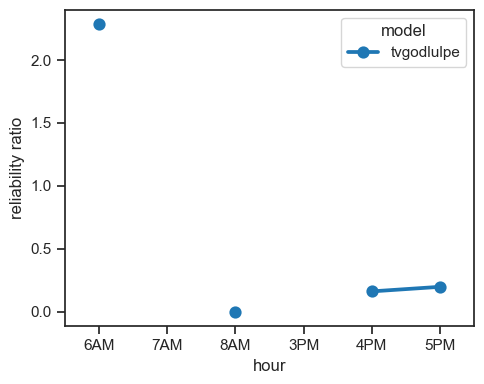

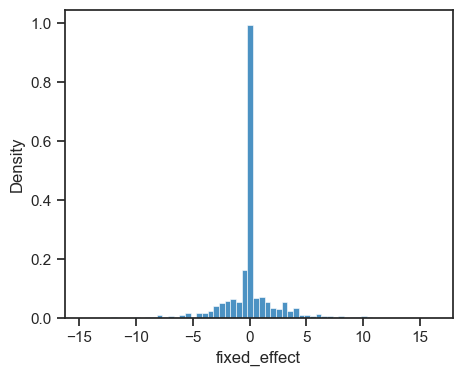

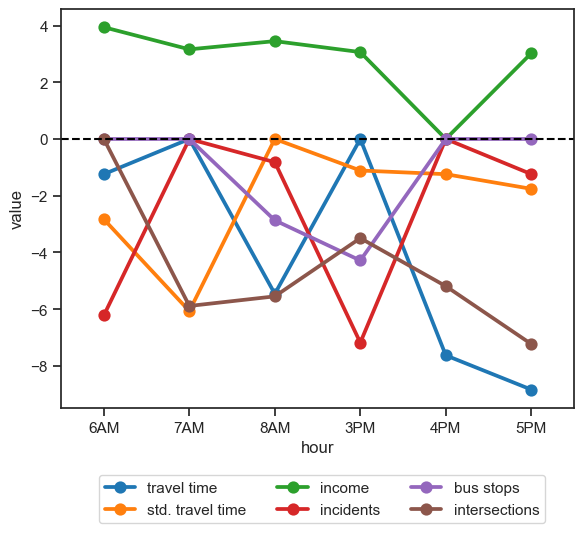

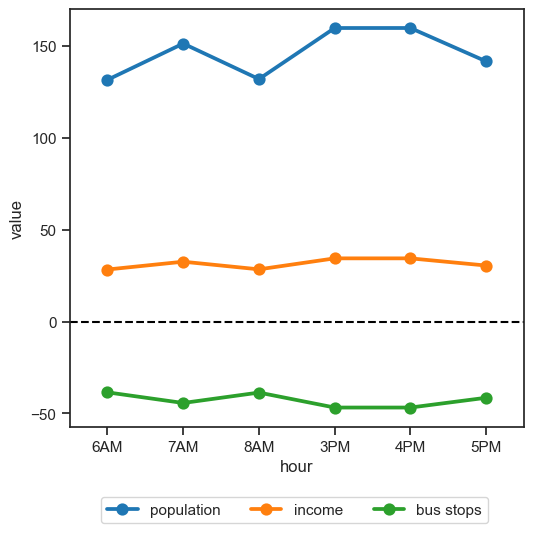

Theta: [[-1.2397  0.     -5.4591  0.     -7.627  -8.8344]
 [-2.8301 -6.0675  0.     -1.1115 -1.2407 -1.7576]
 [ 3.9398  3.1594  3.4493  3.0627  0.      3.0213]
 [-6.2166  0.     -0.8183 -7.1794  0.     -1.2387]
 [ 0.      0.     -2.8675 -4.2838  0.      0.    ]
 [ 0.     -5.8863 -5.5477 -3.4953 -5.1879 -7.2278]]
Kappa: [[131.4958 151.2198 131.8887 159.6779 159.6841 141.5333]
 [ 28.293   32.5369  28.3776  34.3568  34.3581  30.4527]
 [-38.5438 -44.3253 -38.659  -46.8045 -46.8064 -41.486 ]]


In [107]:
# Compute utility parameters over time (heatmap) and value of travel time reliability (lineplot)
theta_df = plot_utility_parameters_periods(models['tvgodlulpe'], period_keys = period_keys, period_feature='hour')
#print(theta_df.values)

plot_rr_by_period(models['tvgodlulpe'], period_keys, model_key = 'tvgodlulpe', period_feature='hour')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (5,4))
sns.histplot(pd.DataFrame({'fixed_effect': np.array(models['tvodlulpe'].fixed_effect)}), stat='density', x="fixed_effect", alpha=0.8, ax = ax, binwidth=0.5)
plt.show()

# Plot parameters by period
theta_df = plot_utility_parameters_periods(models['tvgodlulpe'], period_keys=period_keys, period_feature='hour', plot = False).reset_index().\
    drop(['hour','index'], axis = 1).reset_index().rename(columns = {'index':'period'})

# theta_df = pd.melt(theta_df.assign(rr = theta_df.apply(compute_rr, axis=1)), id_vars = 'period', var_name = 'parameter').assign(group = 'utility')

theta_df = pd.melt(theta_df, id_vars = 'period', var_name = 'parameter').assign(group = 'utility')

kappa_df = pd.concat([pd.DataFrame({'period': [period], 'parameter': [feature], 'value': [models['tvgodlulpe'].kappa[period, i].numpy()]}) for period in range(models['tvgodlulpe'].kappa.shape[0]) for i, feature in enumerate(models['tvgodlulpe'].generation.features)]).assign(group = 'generation')

parameters_df = pd.concat([theta_df, kappa_df]).\
    replace({'tt': 'travel time', 'tt_sd': 'std. travel time', 's': 'intersections', 'bus_stops': 'bus stops', 'median_inc': 'income', 'rr': 'reliability ratio'})

parameters_df['hour'] = parameters_df['period'].map({v:period_keys[period_keys.period_id == k]['hour'].iloc[0] for k,v in models['tvgodlulpe'].period_dict.items()})

fig, ax = plot_parameters(df = parameters_df[parameters_df.group == 'utility'], n_cols_legend = 3, figsize = (6,5.5), hour_label = True)

plt.axhline(0, linestyle ='dashed', color = 'black')

plt.savefig('output/figures/results/fresno-utility-periods-tvgodlulpe.png')

plot_parameters(df = parameters_df[parameters_df.group == 'generation'], n_cols_legend = 3, figsize = (5.5,5.5), hour_label = True)

plt.axhline(0, linestyle ='dashed', color = 'black')

plt.savefig('output/figures/results/fresno-generation-periods-tvgodlulpe.png')

plt.show()

print('Theta:', models['tvgodlulpe'].theta.numpy().T)
print('Kappa:', models['tvgodlulpe'].kappa.numpy().T)

/Users/pablo/github/nesuelogit/src/nesuelogit/visualizations.py:801: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  g = sns.pointplot(data=total_trips_by_hour, x=period_feature, y='total_trips', ax=ax,


(           historic_od         6AM         7AM         8AM         3PM  \
 1618 175     1840.4001    0.002433    0.000784    0.006481    0.001086   
      694     1182.4533    0.002402    0.000707    0.003058    0.000790   
 42   1617    1139.6952    0.011481    0.095370   20.694098    0.031015   
 693  1617    1077.8859    0.011960    0.028408    7.232583    0.043411   
 272  1614     598.5315    0.062406    0.035394    0.054211    0.056272   
 701  1629     577.9746   17.970745   34.519905   28.456955   12.545303   
 226  1651     472.3362   19.911125   22.171087    0.116188    7.414815   
 220  1688     446.1534    0.015211    0.371366    0.002388    0.041251   
 104  1693     430.1766    0.009285    0.008812    0.010331    0.088733   
 871  1679     428.9796    0.021045    0.041034    0.008904    0.974906   
 1615 88       426.7179  507.689880  597.658936  509.572510  636.807983   
 807  1650     418.2822   11.384136   27.781080   14.052054   14.037871   
 752  1633     392.5845  

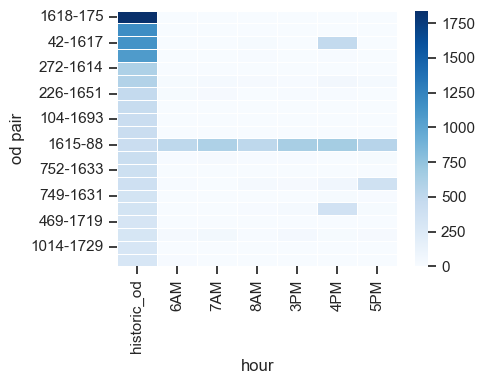

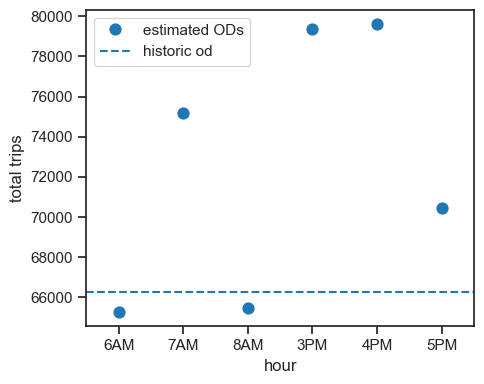

In [108]:
# Plot heatmap with flows of top od pairs
plot_top_od_flows_periods(models['tvgodlulpe'],
                          historic_od= network.q.flatten(),
                          period_keys = period_keys,
                          period_feature='hour', top_k=20)

In [109]:
print(f"theta = "
      f"{dict(zip(models['tvgodlulpe'].utility.true_values.keys(), list(np.mean(models['tvgodlulpe'].theta.numpy(), axis=0))))}")
print(f"kappa= "
      f"{dict(zip(models['tvgodlulpe'].generation.features, list(np.mean(models['tvgodlulpe'].kappa.numpy(), axis=0))))}")

if models['tvgodlulpe'].performance_function.type == 'bpr':
    print(f"alpha = {np.mean(models['tvgodlulpe'].performance_function.alpha): 0.2f}, "
          f"beta  = {np.mean(models['tvgodlulpe'].performance_function.beta): 0.2f}")

print(f"Avg abs diff of observed and estimated OD: "
      f"{np.mean(np.abs(models['tvgodlulpe'].q - network.q.flatten())): 0.2f}")

print(f"Avg observed OD: {np.mean(np.abs(network.q.flatten())): 0.2f}")

theta = {'tt': -3.8600285, 'tt_sd': -2.167906, 'median_inc': 2.7720785, 'incidents': -2.5755026, 'bus_stops': -1.1918722, 'intersections': -4.5575137}
kappa= {'population': 145.91658, 'income': 31.395859, 'bus_stops': -42.770832}
Avg abs diff of observed and estimated OD:  16.68
Avg observed OD:  9.51


# Forecasting

In [ ]:
generation_factors = compute_generation_factors(period_column=XT_train[:, :, -1, None].numpy(),
                                                flow_column=YT_train[:,:,1, None].numpy(), reference_period=10)

print(generation_factors)

n_periods = len(np.unique(XT_train[:, :, -1].numpy().flatten()))

growth_factor = 7.9/6.6

generated_trips = growth_factor*generation_factors.values[:,np.newaxis]*compute_generated_trips(
    q = network.q.flatten()[np.newaxis,:], ods= network.ods, n_nodes = len(network.nodes))

## TVODLULPE

In [ ]:
reference_model = models['tvodlulpe']

In [ ]:
# Create model for inference (make sure that the arguments are the same than those used to create the reference model)
inference_model, _ = create_model(
    n_periods= n_periods, network = network,
    performance_function = create_bpr(network = network, dtype = _DTYPE, alpha_prior = 0.9327, beta_prior = 4.1017),
    od_parameters = ODParameters(key='od',
                                 #initial_values= generation_factors.values[:,np.newaxis]*tntp_network.q.flatten(),
                                 initial_values = tf.stack(q_historic),
                                 historic_values={10: q_historic[0].flatten()},
                                 ods=network.ods,
                                 n_nodes = len(network.nodes),
                                 n_periods=n_periods,
                                 time_varying=True,
                                 trainable=True),
    generation = False,
    utility_trainable = True
)

inference_model.build()
#inference_model.update_predictions(XT_train, update_period_dict = True)

In [ ]:
# inference_model.load_weights("output/models/230616010949_tvgodlulpe_fresno.h5")
inference_model.load_weights(reference_model._filepath_weights)

### - Model estimated with all data from 2019

In [ ]:
# reference_model.load_node_data(node_data)
# This should convergence immediately when the data for prediction is equal to training set
_ = inference_model.predict(XT_train,
                        # period_dict = reference_model.period_dict,
                        node_data=nodes_df,
                        loss_metric=_LOSS_METRIC,
                        pretrain_link_flows = False,
                        batch_size= _BATCH_SIZE,
                        optimizer= _OPTIMIZERS['learning'],
                        loss_weights={'equilibrium': 1},
                        threshold_relative_gap=_RELATIVE_GAP,
                        epochs=100)

In [ ]:
with pd.option_context('display.float_format', '{:0.3g}'.format):
    print('\n')
    training_metrics = inference_model.compute_loss_metrics(metrics={_EVALUATION_METRIC.__name__: _EVALUATION_METRIC, 'mse': mse, 'r2': r2_score},
                                                            X=XT_train, Y=YT_train)
    print(training_metrics)

# model.summary()

In [ ]:
fig, axs = plot_flow_vs_traveltime(model = inference_model,
                        observed_traveltime=inference_model.mask_observed_traveltime(YT_train[:, :, 0]),
                        observed_flow= inference_model.mask_observed_flow(YT_train[:,:,1]),
                        period_col = pd.DataFrame({'period': list(XT_train[:, :, -1].numpy().astype(int).flatten())})['period'].map(dict(zip(period_keys.period_id, period_keys.hour))).values.flatten(),
                        hour_label=True,
                        all_metrics = False
                        )

for ax in axs.reshape(-1):
    ax.legend(loc='lower right', title = 'hour')

plt.show()

### -Make prediction on 2020, the validation set, without computing equilibrium

In [ ]:

_ = inference_model.predict(XT_val,
                            node_data=nodes_df,
                            loss_metric=_LOSS_METRIC,
                            batch_size= _BATCH_SIZE,
                            optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium']),
                            pretrain_link_flows = False,
                            loss_weights={'equilibrium': 1},
                            threshold_relative_gap=float('inf'),  # _RELATIVE_GAP,
                            epochs=100)

In [ ]:
with pd.option_context('display.float_format', '{:0.3g}'.format):
    print('\n')
    validation_metrics = inference_model.compute_loss_metrics(metrics = {_EVALUATION_METRIC.__name__: _EVALUATION_METRIC,
                                                                         'mse': mse, 'r2': r2_score}, X = XT_val, Y = YT_val)
    print(validation_metrics)

In [ ]:
fig, axs = plot_flow_vs_traveltime(model = inference_model,
                        observed_traveltime=inference_model.mask_observed_traveltime(YT_val[:, :, 0]),
                        observed_flow= inference_model.mask_observed_flow(YT_val[:,:,1]),
                        # scatter_kws={"color": sns.color_palette("deep")[0], 's':4, 'alpha': 1}, line_kws={"color": "black"},
                        period_col = pd.DataFrame({'period': list(XT_val[:, :, -1].numpy().astype(int).flatten())})['period'].map(dict(zip(period_keys.period_id, period_keys.hour))).values.flatten(),
                        hour_label=True,
                        all_metrics = False
                        )

for ax in axs.reshape(-1):
    ax.legend(loc='lower right', title = 'hour')

plt.savefig('output/figures/results/fresno-scatter-flow-traveltime-outofsample-tvodlulpe-without-equilibrium.png')

plt.show()

### - Make prediction on 2020, the validation set, computing equilibrium

In [ ]:

_ = inference_model.predict(XT_val,
                            node_data=nodes_df,
                            loss_metric=_LOSS_METRIC,
                            batch_size= _BATCH_SIZE,
                            optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium']),
                            pretrain_link_flows = False,
                            loss_weights={'equilibrium': 1},
                            threshold_relative_gap=_RELATIVE_GAP,
                            epochs=100)

In [ ]:
# with pd.option_context('display.float_format', '{:0.3g}'.format):
#     metrics_df = pd.concat([training_metrics.assign(dataset = 'training'),
#                             validation_metrics.assign(dataset = 'validation')])
#     print(pd.pivot(metrics_df, index=['component', 'dataset'], columns=['metric'])['value'])

with pd.option_context('display.float_format', '{:0.3g}'.format):
    print('\n')
    validation_metrics = inference_model.compute_loss_metrics(metrics = {_EVALUATION_METRIC.__name__: _EVALUATION_METRIC, 'mse': mse, 'r2': r2_score}, X = XT_val, Y = YT_val)
    print(validation_metrics)

In [ ]:
fig, axs = plot_flow_vs_traveltime(model = inference_model,
                        observed_traveltime=inference_model.mask_observed_traveltime(YT_val[:, :, 0]),
                        observed_flow= inference_model.mask_observed_flow(YT_val[:,:,1]),
                        period_col = pd.DataFrame({'period': list(XT_val[:, :, -1].numpy().astype(int).flatten())})['period'].map(dict(zip(period_keys.period_id, period_keys.hour))).values.flatten(),
                        hour_label=True,
                        all_metrics = False
                        )

for ax in axs.reshape(-1):
    ax.legend(loc='lower right', title = 'hour')

plt.savefig('output/figures/results/fresno-scatter-flow-traveltime-outofsample-tvodlulpe-with-equilibrium.png')

plt.show()

## TVGODLULPE

In [ ]:
reference_model = models['tvgodlulpe']

In [ ]:
# Create model for inference (make sure that the arguments are the same than those used to create the reference model)
inference_model, _ = create_tvgodlulpe_model()
inference_model.build()
#inference_model.update_predictions(XT_train, update_period_dict = True)

In [ ]:
# inference_model.load_weights("output/models/230616010949_tvgodlulpe_fresno.h5")
inference_model.load_weights(reference_model._filepath_weights)

### - Model estimated with all data from 2019

In [ ]:
# reference_model.load_node_data(node_data)
# This should convergence immediately when the data for prediction is equal to training set
_ = inference_model.predict(XT_train,
                        # period_dict = reference_model.period_dict,
                        node_data=nodes_df,
                        loss_metric=_LOSS_METRIC,
                        pretrain_link_flows = False,
                        batch_size= _BATCH_SIZE,
                        optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium']),
                        loss_weights={'equilibrium': 1},
                        threshold_relative_gap=float('inf'), #_RELATIVE_GAP
                        epochs=100)

In [ ]:
with pd.option_context('display.float_format', '{:0.3g}'.format):
    print('\n')
    training_metrics = inference_model.compute_loss_metrics(metrics={_EVALUATION_METRIC.__name__: _EVALUATION_METRIC, 'mse': mse, 'r2': r2_score},
                                                            X=XT_train, Y=YT_train)
    print(training_metrics)

# model.summary()

In [ ]:
fig, axs = plot_flow_vs_traveltime(model = inference_model,
                        observed_traveltime=inference_model.mask_observed_traveltime(YT_train[:, :, 0]),
                        observed_flow= inference_model.mask_observed_flow(YT_train[:,:,1]),
                        period_col = pd.DataFrame({'period': list(XT_train[:, :, -1].numpy().astype(int).flatten())})['period'].map(dict(zip(period_keys.period_id, period_keys.hour))).values.flatten(),
                        hour_label=True,
                        all_metrics = False
                        )

for ax in axs.reshape(-1):
    ax.legend(loc='lower right', title = 'hour')

plt.show()

### -Make prediction on 2020, the validation set, without computing equilibrium

In [ ]:

_ = inference_model.predict(XT_val,
                            node_data=nodes_df,
                            loss_metric=_LOSS_METRIC,
                            batch_size= _BATCH_SIZE,
                            optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium']),
                            pretrain_link_flows = False,
                            loss_weights={'equilibrium': 1},
                            threshold_relative_gap=float('inf'),  # _RELATIVE_GAP,
                            epochs=100)

In [ ]:
with pd.option_context('display.float_format', '{:0.3g}'.format):
    print('\n')
    validation_metrics = inference_model.compute_loss_metrics(metrics = {_EVALUATION_METRIC.__name__: _EVALUATION_METRIC, 'mse': mse, 'r2': r2_score}, X = XT_val, Y = YT_val)
    print(validation_metrics)

In [ ]:
fig, axs = plot_flow_vs_traveltime(model = inference_model,
                        observed_traveltime=inference_model.mask_observed_traveltime(YT_val[:, :, 0]),
                        observed_flow= inference_model.mask_observed_flow(YT_val[:,:,1]),
                        # scatter_kws={"color": sns.color_palette("deep")[0], 's':4, 'alpha': 1}, line_kws={"color": "black"},
                        period_col = pd.DataFrame({'period': list(XT_val[:, :, -1].numpy().astype(int).flatten())})['period'].map(dict(zip(period_keys.period_id, period_keys.hour))).values.flatten(),
                        hour_label=True,
                        all_metrics = False
                        )

for ax in axs.reshape(-1):
    ax.legend(loc='lower right', title = 'hour')

plt.savefig('output/figures/results/fresno-scatter-flow-traveltime-outofsample-tvgodlulpe-without-equilibrium.png')

plt.show()

### - Make prediction on 2020, the validation set, computing equilibrium

In [ ]:

_ = inference_model.predict(XT_val,
                            node_data=nodes_df,
                            loss_metric=_LOSS_METRIC,
                            batch_size= _BATCH_SIZE,
                            optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium']),
                            pretrain_link_flows = False,
                            loss_weights={'equilibrium': 1},
                            threshold_relative_gap=_RELATIVE_GAP,
                            epochs=100)

In [ ]:
# with pd.option_context('display.float_format', '{:0.3g}'.format):
#     metrics_df = pd.concat([training_metrics.assign(dataset = 'training'),
#                             validation_metrics.assign(dataset = 'validation')])
#     print(pd.pivot(metrics_df, index=['component', 'dataset'], columns=['metric'])['value'])

with pd.option_context('display.float_format', '{:0.3g}'.format):
    print('\n')
    validation_metrics = inference_model.compute_loss_metrics(metrics = {_EVALUATION_METRIC.__name__: _EVALUATION_METRIC, 'mse': mse, 'r2': r2_score}, X = XT_val, Y = YT_val)
    print(validation_metrics)

In [ ]:
fig, axs = plot_flow_vs_traveltime(model = inference_model,
                        observed_traveltime=inference_model.mask_observed_traveltime(YT_val[:, :, 0]),
                        observed_flow= inference_model.mask_observed_flow(YT_val[:,:,1]),
                        period_col = pd.DataFrame({'period': list(XT_val[:, :, -1].numpy().astype(int).flatten())})['period'].map(dict(zip(period_keys.period_id, period_keys.hour))).values.flatten(),
                        hour_label=True,
                        all_metrics = False
                        )

for ax in axs.reshape(-1):
    ax.legend(loc='lower right', title = 'hour')

plt.savefig('output/figures/results/fresno-scatter-flow-traveltime-outofsample-tvgodlulpe-with-equilibrium.png')

plt.show()

## K-Fold Cross Validation

In [ ]:
models_kfold = {}
metrics_kfold_df = {}
parameters_kfold_df = {}
_N_SPLITS = 5#10

### - Baselines

In [ ]:
# Calculate centroids of links to compute baselines models
links_gdf['X'] = links_gdf.to_crs(2228).geometry.centroid.to_crs(4326).x
links_gdf['Y'] = links_gdf.to_crs(2228).geometry.centroid.to_crs(4326).y
coordinates = links_gdf[['X', 'Y']].values

In [ ]:
# Baselines are computed for every sample
metrics_kfold_df['baselines'] = pd.DataFrame({})
n_samples = XT_val.shape[0]

t0 = time.time()
for i in range(n_samples):

    isl.printer.printIterationBar(i+1, n_samples, prefix='Sample:',length=20)

    metrics_kfold_df['baselines'] = pd.concat([metrics_kfold_df['baselines'],
                                  compute_baseline_predictions_kfold(
                                      metric=_EVALUATION_METRIC,
                                      X = XT_val[i],
                                      y = YT_val[i][:,0][tf.newaxis,:],
                                      coordinates = coordinates,
                                      n_splits = _N_SPLITS, seed = _SEED).assign(component = 'traveltime')])

    metrics_kfold_df['baselines'] = pd.concat([metrics_kfold_df['baselines'],
                                  compute_baseline_predictions_kfold(
                                      metric=_EVALUATION_METRIC,
                                      X = XT_val[i],
                                      y = YT_val[i][:,1][tf.newaxis,:],
                                      coordinates = coordinates,
                                      n_splits = _N_SPLITS, seed = _SEED).assign(component = 'flow')])

    metrics_kfold_df['baselines']['sample'] = i

print(f'runtime: {time.time()-t0:0.1f} [s]')

In [ ]:
metrics_kfold_df['baselines'].to_csv(f"./output/experiments/{ts}_kfold_baselines_{network.key}.csv")

### - TVODLULPE

In [ ]:
n_periods = len(np.unique(XT_train[:, :, -1].numpy().flatten()))

In [ ]:
models_kfold['tvodlulpe'], _ = create_model(
    n_periods= n_periods, network = network,
    performance_function = create_bpr(network = network, dtype = _DTYPE),
    od_parameters = ODParameters(key='od',
                                 #initial_values= generation_factors.values[:,np.newaxis]*tntp_network.q.flatten(),
                                 initial_values = tf.stack(q_historic),
                                 # historic_values={10: q_historic[0].flatten()},
                                 ods=network.ods,
                                 n_nodes = len(network.nodes),
                                 n_periods=n_periods,
                                 time_varying=True,
                                 trainable=True),
    generation = False,
    utility_trainable = True
)

models_kfold['tvodlulpe'].build()

# Prevent to repretrain generation weights
#models_kfold['tvodlulpe'].generation._pretrain_generation_weights = False

In [ ]:
# # Use pretrained weights
models_kfold['tvodlulpe'].load_weights(models['tvodlulpe']._filepath_weights)

In [ ]:
# Assumed there is access to reference OD matrix
q_reference = models_kfold['tvodlulpe'].q

q_reference

In [ ]:
# Add historic OD from estimation in 2019
models_kfold['tvodlulpe'].od.historic_values = q_reference

In [ ]:
# Add deviation respect to historic OD matrix for better generalization.
_LOSS_WEIGHTS_KFOLD ={'od': 1, 'traveltime': 1, 'flow': 1, 'equilibrium': 1}

In [ ]:
metrics_kfold_df['tvodlulpe'], parameters_kfold_df['tvodlulpe'] = train_kfold(
    n_splits=_N_SPLITS,
    random_state = _SEED,
    model = models_kfold['tvodlulpe'],
    X = XT_val, Y = YT_val,
    optimizers= {'learning': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['learning']),
                 'equilibrium': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium'])
                 },
    node_data = nodes_df,
    loss_weights=_LOSS_WEIGHTS_KFOLD,
    loss_metric=_LOSS_METRIC,
    evaluation_metric=_EVALUATION_METRIC,
    equilibrium_stage=_EQUILIBRIUM_STAGE['tvodlulpe'],
    epochs_print_interval= _EPOCHS,
    pretrain_link_flows = True,
    threshold_relative_gap= _RELATIVE_GAP,
    batch_size=_BATCH_SIZE,
    epochs = _EPOCHS,
)

In [ ]:
metrics_kfold_df['tvodlulpe'].to_csv(f"./output/experiments/{ts}_kfold_{network.key}.csv")

# TODO: Add coefficient of variation and save experiments results, compute percentage reduction between final and initial
with pd.option_context('display.float_format', '{:0.3g}'.format):
    print(metrics_kfold_df['tvodlulpe'][metrics_kfold_df['tvodlulpe'].component.isin(['flow','traveltime'])].\
          groupby(['dataset', 'component', 'metric', 'stage'])['value'].\
          aggregate(['median', 'mean', 'std']))

In [ ]:
fig, axs = plot_metrics_kfold(df = metrics_kfold_df['tvodlulpe'][metrics_kfold_df['tvodlulpe'].component.isin(['flow','traveltime'])],
                              metric_name = _EVALUATION_METRIC.__name__, model_name = 'tvodlulpe', showfliers = True)

for ax in axs.reshape(-1):
    ax.set_ylim(bottom = 0)

plt.savefig(f'output/figures/results/fresno-kfold-{_EVALUATION_METRIC.__name__}-tvodlulpe.png')

plt.show()

In [ ]:
parameters_kfold_df['tvodlulpe']['hour'] = parameters_kfold_df['tvodlulpe'].period.replace({v: k for k, v in models_kfold['tvodlulpe'].period_dict.items()}). \
    replace(dict(zip(period_keys.period_id, period_keys.hour)))

parameters_kfold_df['tvodlulpe']['parameter'] = parameters_kfold_df['tvodlulpe']['parameter'].\
    replace({'tt': 'travel time', 'median_inc': 'income', 'tt_sd': 'std. travel time', 'bus_stops': 'bus stops', 'vot': 'reliability ratio'})

parameters_kfold_df['tvodlulpe']['hour'] \
    = parameters_kfold_df['tvodlulpe']['period'].map({v:period_keys[period_keys.period_id == k]['hour'].iloc[0] for k,v in models_kfold['tvodlulpe'].period_dict.items()})

parameters_kfold_df['tvodlulpe'] = parameters_kfold_df['tvodlulpe'][parameters_kfold_df['tvodlulpe'].parameter != 'reliability ratio']

fig, axs = plot_parameters_kfold(df = parameters_kfold_df['tvodlulpe'][parameters_kfold_df['tvodlulpe'].group == 'utility'], n_cols_legend = 2, figsize = (5.5,5.5), hour_label = True)

plt.axhline(0, linestyle ='dashed', color = 'black')

plt.savefig('output/figures/results/fresno-kfold-utility-periods-tvodlulpe.png')

plt.show()

### - TVGODLULPE

In [ ]:
n_periods = len(np.unique(XT_train[:, :, -1].numpy().flatten()))

In [ ]:
models_kfold['tvgodlulpe'], _ = create_model(
    n_periods = n_periods,
    network = network,
    performance_function = create_mlp(network = network,
                                      poly_order = 4, pretrain = False, link_specific = False),
    historic_g= generated_trips,
    generation = True,
    generation_trainable = True,
    utility_trainable = True)

models_kfold['tvgodlulpe'].build()

# Prevent to repretrain generation weights
models_kfold['tvgodlulpe'].generation._pretrain_generation_weights = False

In [ ]:
# Use pretrained weights
models_kfold['tvgodlulpe'].load_weights(models['tvgodlulpe']._filepath_weights)

In [ ]:
# Assumed there is access to reference OD matrix
q_reference = models_kfold['tvgodlulpe'].q

q_reference

In [ ]:
# Add historic OD from estimation in 2019
models_kfold['tvgodlulpe'].od.historic_values = q_reference

In [ ]:
# Add deviation respect to historic OD matrix for better generalization.
_LOSS_WEIGHTS_KFOLD ={'od': 1, 'traveltime': 1, 'flow': 1, 'equilibrium': 1}

In [ ]:
metrics_kfold_df['tvgodlulpe'], parameters_kfold_df['tvgodlulpe'] = train_kfold(
    n_splits=_N_SPLITS ,
    random_state = _SEED,
    model = models_kfold['tvgodlulpe'],
    X = XT_val, Y = YT_val,
    optimizers= {'learning': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['learning']),
                 'equilibrium': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium'])
                 },
    node_data = nodes_df,
    loss_weights=_LOSS_WEIGHTS_KFOLD,
    loss_metric=_LOSS_METRIC,
    evaluation_metric=_EVALUATION_METRIC,
    equilibrium_stage=_EQUILIBRIUM_STAGE['tvgodlulpe'],
    pretrain_link_flows = True,
    epochs_print_interval= _EPOCHS,
    threshold_relative_gap= _RELATIVE_GAP,
    batch_size=_BATCH_SIZE,
    epochs = _EPOCHS,
)

In [ ]:
filename = f"{ts}_kfold_{network.key}.csv"
metrics_kfold_df['tvgodlulpe'].to_csv(f"./output/experiments/{filename}")
print(f"File {filename} written with k-fold results for TVGODULPE model")


# TODO: Add coefficient of variation and save experiments results, compute percentage reduction between final and initial
with pd.option_context('display.float_format', '{:0.3g}'.format):
    print(metrics_kfold_df['tvgodlulpe'][metrics_kfold_df['tvgodlulpe'].component.isin(['flow','traveltime'])].\
          groupby(['dataset', 'component', 'metric', 'stage'])['value'].\
          aggregate(['median', 'mean', 'std']))

In [ ]:
print(metrics_kfold_df['tvgodlulpe']['stage'])

In [ ]:
fig, axs = plot_metrics_kfold(df = metrics_kfold_df['tvgodlulpe'][metrics_kfold_df['tvgodlulpe'].component.isin(['flow','traveltime'])], model_name = 'tvgodlulpe', metric_name = _EVALUATION_METRIC.__name__, showfliers = True)

for ax in axs.reshape(-1):
    ax.set_ylim(bottom = 0)

plt.savefig(f'output/figures/results/fresno-kfold-{_EVALUATION_METRIC.__name__}-tvgodlulpe.png')

plt.show()

In [ ]:
parameters_kfold_df['tvgodlulpe']['hour'] = parameters_kfold_df['tvgodlulpe'].period.replace({v: k for k, v in models_kfold['tvgodlulpe'].period_dict.items()}). \
    replace(dict(zip(period_keys.period_id, period_keys.hour)))

parameters_kfold_df['tvgodlulpe']['parameter'] = parameters_kfold_df['tvgodlulpe']['parameter'].\
    replace({'tt': 'travel time', 'median_inc': 'income', 'tt_sd': 'std. travel time', 'bus_stops': 'bus stops', 'vot': 'reliability ratio'})

parameters_kfold_df['tvgodlulpe']['hour'] \
    = parameters_kfold_df['tvgodlulpe']['period'].map({v:period_keys[period_keys.period_id == k]['hour'].iloc[0] for k,v in models_kfold['tvgodlulpe'].period_dict.items()})

parameters_kfold_df['tvgodlulpe'] = parameters_kfold_df['tvgodlulpe'][parameters_kfold_df['tvgodlulpe'].parameter != 'reliability ratio']

fig, axs = plot_parameters_kfold(df = parameters_kfold_df['tvgodlulpe'][parameters_kfold_df['tvgodlulpe'].group == 'utility'], n_cols_legend = 2, figsize = (5.5,5.5), hour_label = True)

plt.axhline(0, linestyle ='dashed', color = 'black')

plt.savefig('output/figures/results/fresno-kfold-utility-periods-tvgodlulpe.png')

plt.show()

fig, axs = plot_parameters_kfold(df = parameters_kfold_df['tvgodlulpe'][parameters_kfold_df['tvgodlulpe'].group == 'generation'], n_cols_legend = 3, figsize = (5.5,5.5), hour_label = True)

plt.axhline(0, linestyle ='dashed', color = 'black')

plt.savefig('output/figures/results/fresno-kfold-generation-periods-tvgodlulpe.png')

plt.show()

### Comparison between our model and benchmarks

In [ ]:
metrics_kfold_plot_df = metrics_kfold_df['tvgodlulpe'][
        (metrics_kfold_df['tvgodlulpe'].component != 'equilibrium') & (metrics_kfold_df['tvgodlulpe'].metric == _EVALUATION_METRIC.__name__) &
        (metrics_kfold_df['tvgodlulpe'].dataset == 'validation') & (metrics_kfold_df['tvgodlulpe'].stage == 'final')].\
        assign(model = 'tvgodlulpe')

In [ ]:
metrics_kfold_df['baselines'] \
    = metrics_kfold_df['baselines'].groupby(['fold', 'model', 'component'])[['value']].mean().reset_index()

metrics_kfold_plot_df = pd.concat([metrics_kfold_df['baselines'][['model','component','value']],
                                   metrics_kfold_plot_df[['model','component','value']]])

In [ ]:
means_mapes = metrics_kfold_plot_df.groupby(['component','model'])['value'].mean().reset_index().rename(columns={'value':'mean'})
se_mapes = metrics_kfold_plot_df.groupby(['component','model'])['value'].agg(['std', 'count']).apply(lambda row: row['std'] / np.sqrt(row['count']), axis=1).reset_index().rename(columns={0:'se'})

pd.merge(means_mapes, se_mapes).sort_values(by = ['component', 'mean'])

In [ ]:
# Note: Result from ordinary kriging are removed due to unstable estimates and extremely large values of evaluation metric for travel time
plot_baselines_kfold(df = metrics_kfold_plot_df[metrics_kfold_plot_df.model != 'ordinary_kriging'],
                     metric_name=_EVALUATION_METRIC.__name__, sharex=True, sharey=True, showfliers = False)

plt.show()

In [137]:
# Link-level spatial information
links_gdf['link_key'] = pd.Categorical(links_gdf['key'].apply(ast.literal_eval), list(network.links_dict.keys()))

# Create dataframe with data collected in 2020 during peak hours only
model_df = df[(df.hour.isin([6,7,8, 15,16,17])) & (df['year']==2020)].sort_values(['period','link_key'])
# links_gdf = links_gdf.sort_values(['link_key'])

# Build dataset witg data collected between 4-5pm in the first Tuesdays of Oct 2019 and 2020
benchmark_df = df[(df.hour == 16) & df['date'].isin(['2019-10-01', '2020-10-06'])].sort_values(['period','link_key'])

fig_speed, fig_flow = plot_congestion_maps(model=inference_model, model_df=model_df, benchmark_df = benchmark_df,
                     gdf=links_gdf.sort_values(['link_key']), features=_FEATURES_Z, cmap = 'viridis')

ValueError: Length of values (188214) does not match length of index (14478)

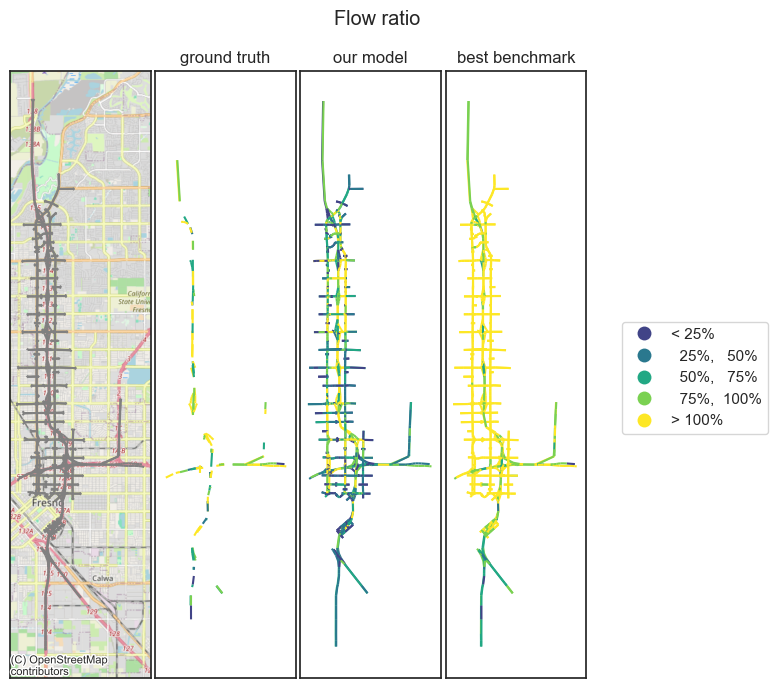

In [111]:
fig_flow

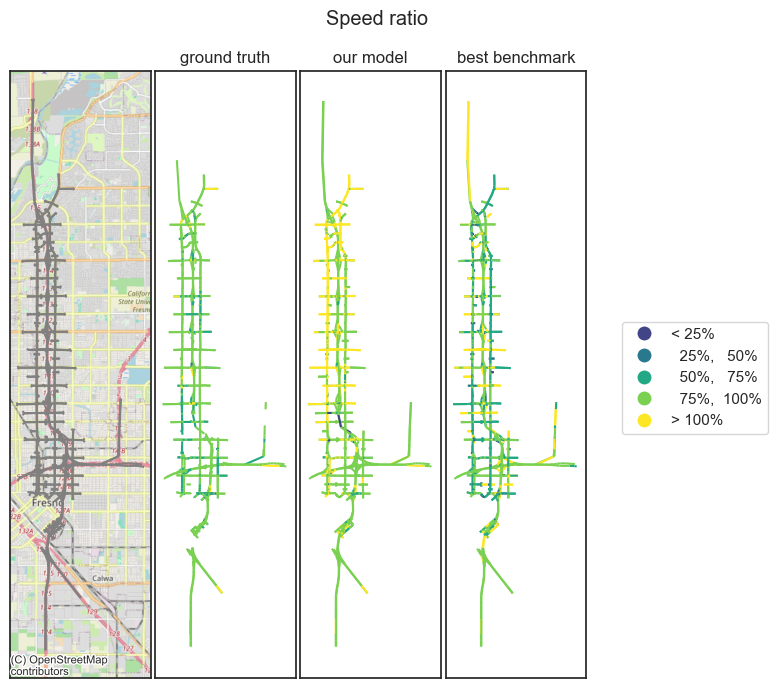

In [112]:
fig_speed

## Write estimation results

In [ ]:
train_results_df, val_results_df \
    = map(lambda x: pd.concat([results.assign(model = model)[['model'] + list(results.columns)]
                               for model, results in x.items()],axis = 0), [train_results_dfs, val_results_dfs])

train_filename = f"{ts}_train_results_{network.key}.csv"
val_filename = f"{ts}_validation_results_{network.key}.csv"
train_results_df.to_csv(f"./output/tables/{train_filename}")
print(f'File {train_filename} was written')
val_results_df.to_csv(f"./output/tables/{val_filename}")
print(f'File {val_filename} was written')

## Summary of parameter estimates

### All models

In [ ]:
models

In [ ]:
results = pd.DataFrame({'parameter': [], 'model': []})

for model_key, model in models.items():
    model_results = {**dict(zip(['tt'] + _FEATURES_Z, list(np.mean(model.theta.numpy(), axis=0)))),
                     **{'rr': float(model.get_parameters_estimates().eval('tt_sd/tt').iloc[0]),
                        'fixed_effect_mean': np.mean(model.fixed_effect),
                        'fixed_effect_std': np.std(model.fixed_effect),
                        'od_mean': np.mean(model.q),
                        'od_std': np.std(model.q)
                        }}

    if model.performance_function.type == 'bpr':
        model_results = {**model_results, **{'alpha_mean': np.mean(model.performance_function.alpha),
                                             'alpha_std': np.std(model.performance_function.alpha),
                                             'beta_mean': np.mean(model.performance_function.beta),
                                             'beta_std': np.std(model.performance_function.beta)}}

    model_results = pd.DataFrame({'parameter': model_results.keys(), 'values': model_results.values()}). \
        assign(model=model_key)

    results = pd.concat([results, model_results])

In [ ]:
print(results.pivot_table(index = ['parameter'], columns = 'model', values = 'values', sort=False).round(4))

### TVGODLULPE

In [ ]:
# Stats by period
model = models['tvgodlulpe']

with pd.option_context('display.float_format', '{:0.4f}'.format):
    print('theta:', pd.DataFrame(model.theta.numpy().T))

In [ ]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    print('kappa:', pd.DataFrame(model.kappa.numpy().T))

In [ ]:
# with pd.option_context('display.float_format', '{:0.1f}'.format):
with pd.option_context('display.float_format', '{:0.4f}'.format):
    print('OD matrix', pd.DataFrame({'od_mean': np.mean(model.q,axis = 1), 'od_std': np.std(model.q, axis = 1), 'od_total':np.sum(model.q,axis = 1)}).T)

## Summary of models goodness of fit

In [ ]:
results_losses = pd.DataFrame({})
loss_columns = ['loss_flow', 'loss_traveltime', 'loss_equilibrium', 'loss_total']

for model_key, model in models.items():
    results_losses_model = model.split_results(train_results_dfs[model_key])[1].assign(model=model_key)
    results_losses_model = results_losses_model[results_losses_model.epoch == _EPOCHS['learning']].iloc[[0]]
    results_losses = pd.concat([results_losses, results_losses_model])

results_losses[loss_columns] = (results_losses[loss_columns] - 1) * 100

In [ ]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    print(results_losses[['model'] + list(results_losses.columns)])

## Plot of convergence toward true rr across models

In [ ]:
train_estimates = {}
train_losses = {}

for model_key, model in models.items():
    train_estimates[model_key], train_losses[model_key] = model.split_results(results=train_results_dfs[model_key])

    train_estimates[model_key]['model'] = model_key

train_estimates_df = pd.concat(train_estimates.values())

train_estimates_df['rr'] = train_estimates_df['tt_sd'] / train_estimates_df['tt']

estimates = train_estimates_df[['epoch', 'model', 'rr']].reset_index().drop('index', axis=1)
#estimates = estimates[estimates.epoch != 0]

fig, ax = plt.subplots(nrows=1, ncols=1)

g = sns.lineplot(data=estimates, x='epoch', hue='model', y='rr')

# ax.hlines(y=compute_rr(models.popitem().true_values), xmin=estimates['epoch'].min(), xmax=estimates['epoch'].max(), linestyle='--', label = 'truth')

ax.set_ylabel('reliability ratio')

ax.set_xticks(np.arange(estimates['epoch'].min(), estimates['epoch'].max() + 2, _XTICKS_SPACING))

#ax.set_yscale('log')
#plt.ylim(ymin=0)
plt.show()

## Plot of reliability ratio by hour for all models

In [ ]:
reliability_ratios = plot_rr_by_period_models(models, period_keys, period_feature='hour', join = True)

plt.savefig('output/figures/results/fresno-reliability-ratios-periods.png')

plt.show()

In [ ]:
print(reliability_ratios)

In [ ]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    print(reliability_ratios[reliability_ratios.model == 'tvgodlulpe'][['hour','rr']].T)

In [ ]:
print(reliability_ratios.groupby('model')[['rr']].mean().round(4))

## Plot of total trips by hour for all models

In [ ]:
total_trips = plot_total_trips_models(models = models, period_feature = 'hour', period_keys = period_keys,
                                      historic_od = network.q.flatten(), join = True)

plt.savefig('output/figures/results/fresno-total-trips-periods.png')

plt.show()

In [ ]:
print(total_trips)

In [ ]:
total_trips.groupby('model')[['total_trips']].mean().round(1)

In [ ]:
total_trips.groupby('model')[['total_trips']].sum().round(1)



## Global runtime

In [ ]:
print(f'runtime: {time.time()-t0_global:0.1f} [s]')